In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/traffic-crashes/Traffic_Crashes_-_People_20241006.csv
/kaggle/input/traffic-crashes/Traffic_Crashes_-_Crashes_20241006.csv
/kaggle/input/traffic-crashes/Traffic_Crashes_-_Vehicles_20241009.csv


In [2]:
# Import other dependencies
import seaborn as sns
from scipy import stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipe

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,\
precision_recall_fscore_support, f1_score, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score,\
classification_report
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_validate, cross_val_predict, cross_val_score
import warnings
warnings.filterwarnings('ignore')

### Loading Datasets

1. **Crashes Dataset**

In [3]:
crashes_df = pd.read_csv('/kaggle/input/traffic-crashes/Traffic_Crashes_-_Crashes_20241006.csv')

crashes_df.head()

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,23a79931ef555d54118f64dc9be2cf2dbf59636ce253f7...,NaN,09/05/2023 07:05:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DUSK,ANGLE,"FIVE POINT, OR MORE",...,2.0,0.0,2.0,0.0,19,3,9,NaN,NaN,NaN
1,2675c13fd0f474d730a5b780968b3cafc7c12d7adb661f...,NaN,09/22/2023 06:45:00 PM,50,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",REAR END,DIVIDED - W/MEDIAN BARRIER,...,0.0,0.0,2.0,0.0,18,6,9,NaN,NaN,NaN
2,5f54a59fcb087b12ae5b1acff96a3caf4f2d37e79f8db4...,NaN,07/29/2023 02:45:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0,0.0,1.0,0.0,14,7,7,41.85412,-87.665902,POINT (-87.665902342962 41.854120262952)
3,7ebf015016f83d09b321afd671a836d6b148330535d5df...,NaN,08/09/2023 11:00:00 PM,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE SAME DIRECTION,NOT DIVIDED,...,0.0,0.0,2.0,0.0,23,4,8,NaN,NaN,NaN
4,6c1659069e9c6285a650e70d6f9b574ed5f64c12888479...,NaN,08/18/2023 12:50:00 PM,15,OTHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,OTHER,...,1.0,0.0,1.0,0.0,12,6,8,NaN,NaN,NaN


We are first going to create 2 functions:
* One that summarises missing values
* Another for dropping any column in our datasets whose missing values are above our set threshold 75%

In [4]:
def missing_values_summary(df):
    # Calculate the number of missing values and their percentage
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / df.shape[0]) * 100
    
    # Create a DataFrame with the results
    missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

    # Filter out columns with no missing values and sort by 'Missing Values'
    missing_data = missing_data[missing_data['Missing Values'] > 0].sort_values(by='Missing Values', ascending=False)

    return missing_data

In [5]:
def drop_high_missing_columns(df, threshold=75):
    # Calculate the percentage of missing values
    missing_percentage = (df.isnull().sum() / df.shape[0]) * 100

    # Filter columns with missing percentage greater than the threshold
    columns_to_drop = missing_percentage[missing_percentage > threshold].index

    # Drop the columns
    df_dropped = df.drop(columns=columns_to_drop)

    return df_dropped

#### **Exploring Crashes Dataset**

Checking the columns we have in our `Crashes` dataset

In [6]:
crashes_df.columns

Index(['CRASH_RECORD_ID', 'CRASH_DATE_EST_I', 'CRASH_DATE',
       'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
       'TRAFFICWAY_TYPE', 'LANE_CNT', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
       'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'INTERSECTION_RELATED_I',
       'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE',
       'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I',
       'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I', 'NUM_UNITS',
       'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
       'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
       'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
       'INJURIES_UNKNOWN', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH',
       'LATITUDE', 

In [7]:
# Check the number of rows and columns 
crashes_df.shape

(880093, 48)

From the above output, we can note that we have 880093 rows and 48 columns

In [8]:
crashes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880093 entries, 0 to 880092
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                880093 non-null  object 
 1   CRASH_DATE_EST_I               65222 non-null   object 
 2   CRASH_DATE                     880093 non-null  object 
 3   POSTED_SPEED_LIMIT             880093 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         880093 non-null  object 
 5   DEVICE_CONDITION               880093 non-null  object 
 6   WEATHER_CONDITION              880093 non-null  object 
 7   LIGHTING_CONDITION             880093 non-null  object 
 8   FIRST_CRASH_TYPE               880093 non-null  object 
 9   TRAFFICWAY_TYPE                880093 non-null  object 
 10  LANE_CNT                       199017 non-null  float64
 11  ALIGNMENT                      880093 non-null  object 
 12  ROADWAY_SURFACE_COND          

Using our function to check on columns with missing values in descending order

In [9]:
missing_values_summary(crashes_df)

,Missing Values,Percentage
WORKERS_PRESENT_I,878817,99.855015
DOORING_I,877309,99.683670
WORK_ZONE_TYPE,876260,99.564478
WORK_ZONE_I,875130,99.436082
PHOTOS_TAKEN_I,868157,98.643780
STATEMENTS_TAKEN_I,859949,97.711151
NOT_RIGHT_OF_WAY_I,839883,95.431165
CRASH_DATE_EST_I,814871,92.589192
LANE_CNT,681076,77.386822
INTERSECTION_RELATED_I,678237,77.064242


We have features with more than 75% missing values and for this reason they are going to be dropped and after which, all the null values are also going to be dropped so that we remain with clean `Crashes` dataset

Let's look at the statistical summary

In [10]:
# Statistical summary
crashes_df.describe()

,POSTED_SPEED_LIMIT,LANE_CNT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,880093.000000,1.990170e+05,880093.000000,880088.000000,880093.000000,878152.000000,878152.000000,878152.000000,878152.000000,878152.000000,878152.000000,878152.0,880093.000000,880093.000000,880093.000000,873822.000000,873822.000000
mean,28.418012,1.332970e+01,3687.502824,1244.779543,2.035159,0.193529,0.001189,0.019830,0.108621,0.063889,2.001315,0.0,13.204356,4.121138,6.641602,41.855119,-87.673679
std,6.121844,2.961542e+03,2880.803121,705.000740,0.452488,0.571493,0.037376,0.164983,0.425074,0.324960,1.157131,0.0,5.572912,1.981148,3.363514,0.334180,0.678922
min,0.000000,0.000000e+00,0.000000,111.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,-87.936193
25%,30.000000,2.000000e+00,1250.000000,715.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,9.000000,2.000000,4.000000,41.783061,-87.721824
50%,30.000000,2.000000e+00,3201.000000,1212.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,14.000000,4.000000,7.000000,41.874952,-87.674226
75%,30.000000,4.000000e+00,5564.000000,1822.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,17.000000,6.000000,9.000000,41.924519,-87.633513
max,99.000000,1.191625e+06,451100.000000,6100.000000,18.000000,21.000000,4.000000,10.000000,21.000000,15.000000,61.000000,0.0,23.000000,7.000000,12.000000,42.022780,0.000000


Dropping features with missing values above 75% threshold

In [11]:
crashes_df = drop_high_missing_columns(crashes_df, threshold=75)

Having a look at the missing values summary after dropping the features

In [12]:
missing_values_summary(crashes_df)

,Missing Values,Percentage
HIT_AND_RUN_I,604145,68.645586
REPORT_TYPE,27030,3.071266
LOCATION,6271,0.712538
LONGITUDE,6271,0.712538
LATITUDE,6271,0.712538
MOST_SEVERE_INJURY,1955,0.222136
INJURIES_FATAL,1941,0.220545
INJURIES_TOTAL,1941,0.220545
INJURIES_NO_INDICATION,1941,0.220545
INJURIES_REPORTED_NOT_EVIDENT,1941,0.220545


#### **Exploring People Dataset**

Checking the columns of `People` dataset

In [13]:
people_df = pd.read_csv('/kaggle/input/traffic-crashes/Traffic_Crashes_-_People_20241006.csv', low_memory=False)

people_df.head()

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,VEHICLE_ID,CRASH_DATE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,...,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,O749947,DRIVER,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,M,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O871921,DRIVER,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,827212.0,04/13/2020 10:50:00 PM,NaN,CHICAGO,IL,60620,M,...,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,O10018,DRIVER,71162af7bf22799b776547132ebf134b5b438dcf3dac6b...,9579.0,11/01/2015 05:00:00 AM,NaN,NaN,NaN,NaN,X,...,NaN,IMPROPER BACKING,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
3,O10038,DRIVER,c21c476e2ccc41af550b5d858d22aaac4ffc88745a1700...,9598.0,11/01/2015 08:00:00 AM,NaN,NaN,NaN,NaN,X,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,O10039,DRIVER,eb390a4c8e114c69488f5fb8a097fe629f5a92fd528cf4...,9600.0,11/01/2015 10:15:00 AM,NaN,NaN,NaN,NaN,X,...,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN


In [14]:
people_df.columns

Index(['PERSON_ID', 'PERSON_TYPE', 'CRASH_RECORD_ID', 'VEHICLE_ID',
       'CRASH_DATE', 'SEAT_NO', 'CITY', 'STATE', 'ZIPCODE', 'SEX', 'AGE',
       'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS', 'SAFETY_EQUIPMENT',
       'AIRBAG_DEPLOYED', 'EJECTION', 'INJURY_CLASSIFICATION', 'HOSPITAL',
       'EMS_AGENCY', 'EMS_RUN_NO', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY',
       'PEDPEDAL_LOCATION', 'BAC_RESULT', 'BAC_RESULT VALUE',
       'CELL_PHONE_USE'],
      dtype='object')

In [15]:
# Checking the number of columns and rows
people_df.shape

(1932814, 29)

From the output, we have 1932814 rows and 29 columns

In [16]:
# Dataset information
people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1932814 entries, 0 to 1932813
Data columns (total 29 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   PERSON_ID              object 
 1   PERSON_TYPE            object 
 2   CRASH_RECORD_ID        object 
 3   VEHICLE_ID             float64
 4   CRASH_DATE             object 
 5   SEAT_NO                float64
 6   CITY                   object 
 7   STATE                  object 
 8   ZIPCODE                object 
 9   SEX                    object 
 10  AGE                    float64
 11  DRIVERS_LICENSE_STATE  object 
 12  DRIVERS_LICENSE_CLASS  object 
 13  SAFETY_EQUIPMENT       object 
 14  AIRBAG_DEPLOYED        object 
 15  EJECTION               object 
 16  INJURY_CLASSIFICATION  object 
 17  HOSPITAL               object 
 18  EMS_AGENCY             object 
 19  EMS_RUN_NO             object 
 20  DRIVER_ACTION          object 
 21  DRIVER_VISION          object 
 22  PHYSICAL_CONDITION

Check on the missing values summary in descending order

In [17]:
missing_values_summary(people_df)

,Missing Values,Percentage
CELL_PHONE_USE,1931654,99.939984
BAC_RESULT VALUE,1930698,99.890522
EMS_RUN_NO,1900336,98.319652
PEDPEDAL_VISIBILITY,1895221,98.055012
PEDPEDAL_ACTION,1895153,98.051494
PEDPEDAL_LOCATION,1895153,98.051494
EMS_AGENCY,1738265,89.934417
HOSPITAL,1617886,83.706244
SEAT_NO,1541715,79.765306
DRIVERS_LICENSE_CLASS,991106,51.277878


In [18]:
# Statistical summary
people_df.describe()

,VEHICLE_ID,SEAT_NO,AGE,BAC_RESULT VALUE
count,1.893365e+06,391099.000000,1.369426e+06,2116.000000
mean,9.094490e+05,4.164818,3.791410e+01,0.170747
std,5.288295e+05,2.216350,1.708989e+01,0.103180
min,2.000000e+00,1.000000,-1.770000e+02,0.000000
25%,4.512990e+05,3.000000,2.500000e+01,0.120000
50%,9.004650e+05,3.000000,3.500000e+01,0.170000
75%,1.369158e+06,5.000000,5.000000e+01,0.220000
max,1.830378e+06,12.000000,1.100000e+02,1.000000


Drop columns whose missing values are above 75% threshold

In [19]:
people_df = drop_high_missing_columns(people_df, threshold=75)

Re-check the missing values summary after dropping the columns

In [20]:
missing_values_summary(people_df)

,Missing Values,Percentage
DRIVERS_LICENSE_CLASS,991106,51.277878
DRIVERS_LICENSE_STATE,801540,41.470105
ZIPCODE,639846,33.104375
AGE,563388,29.148589
CITY,526566,27.243491
STATE,505205,26.138314
DRIVER_VISION,395153,20.444440
DRIVER_ACTION,394562,20.413863
BAC_RESULT,393617,20.364970
PHYSICAL_CONDITION,393509,20.359383


#### **Exploring Vehicle Dataset**

In [21]:
vehicle_df = pd.read_csv('/kaggle/input/traffic-crashes/Traffic_Crashes_-_Vehicles_20241009.csv')

vehicle_df.head()

,CRASH_UNIT_ID,CRASH_RECORD_ID,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,...,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
0,1717556,7b1763088507f77e0e552c009a6bf89a4d6330c7527706...,12/06/2023 03:24:00 PM,1,DRIVER,NaN,1634931.0,NaN,NISSAN,SENTRA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1717574,2603ff5a88f0b9b54576934c5ed4e4a64e8278e005687b...,12/06/2023 04:00:00 PM,2,DRIVER,NaN,1634978.0,NaN,CHRYSLER,SEBRING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1717579,a52ef70e33d468b855b5be44e8638a564434dcf99c0edf...,12/06/2023 04:30:00 PM,1,DRIVER,NaN,1634948.0,NaN,SUBARU,OUTBACK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1720118,609055f4b1a72a44d6ec40ba9036cefd7c1287a755eb6c...,12/10/2023 12:12:00 PM,1,DRIVER,NaN,1637401.0,NaN,TOYOTA,RAV4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1720119,609055f4b1a72a44d6ec40ba9036cefd7c1287a755eb6c...,12/10/2023 12:12:00 PM,2,DRIVER,NaN,1637408.0,NaN,SUBARU,OUTBACK,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check the columns in `Vehicle` dataset

In [22]:
vehicle_df.columns

Index(['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO',
       'UNIT_TYPE', 'NUM_PASSENGERS', 'VEHICLE_ID', 'CMRC_VEH_I', 'MAKE',
       'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT',
       'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER',
       'TOWED_I', 'FIRE_I', 'OCCUPANT_CNT', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY',
       'TOWED_TO', 'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I',
       'AREA_04_I', 'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I',
       'AREA_09_I', 'AREA_10_I', 'AREA_11_I', 'AREA_12_I', 'AREA_99_I',
       'FIRST_CONTACT_POINT', 'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO',
       'COMMERCIAL_SRC', 'GVWR', 'CARRIER_NAME', 'CARRIER_STATE',
       'CARRIER_CITY', 'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'UN_NO',
       'HAZMAT_PRESENT_I', 'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO',
       'MCS_REPORT_I', 'MCS_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I',
       'MCS_VIO_CAUSE_CRASH_I', 'IDOT_PERMIT_NO', 'WIDE_LOAD_I',
       'TRAILER1_

In [23]:
# Cheeck the number of columns and rows
vehicle_df.shape

(1797799, 71)

from the above output, we have 1797799 rows and 71 columns

In [24]:
# Data information
vehicle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797799 entries, 0 to 1797798
Data columns (total 71 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   CRASH_UNIT_ID             int64  
 1   CRASH_RECORD_ID           object 
 2   CRASH_DATE                object 
 3   UNIT_NO                   int64  
 4   UNIT_TYPE                 object 
 5   NUM_PASSENGERS            float64
 6   VEHICLE_ID                float64
 7   CMRC_VEH_I                object 
 8   MAKE                      object 
 9   MODEL                     object 
 10  LIC_PLATE_STATE           object 
 11  VEHICLE_YEAR              float64
 12  VEHICLE_DEFECT            object 
 13  VEHICLE_TYPE              object 
 14  VEHICLE_USE               object 
 15  TRAVEL_DIRECTION          object 
 16  MANEUVER                  object 
 17  TOWED_I                   object 
 18  FIRE_I                    object 
 19  OCCUPANT_CNT              float64
 20  EXCEED_SPEED_LIMIT_I    

Let's look at the missing values summary for the `Vehicle` dataset

In [25]:
missing_values_summary(vehicle_df)

,Missing Values,Percentage
HAZMAT_REPORT_NO,1797798,99.999944
MCS_REPORT_NO,1797792,99.999611
HAZMAT_NAME,1797736,99.996496
TRAILER2_LENGTH,1797729,99.996106
WIDE_LOAD_I,1797638,99.991045
...,...,...
VEHICLE_USE,41925,2.332018
MANEUVER,41925,2.332018
TRAVEL_DIRECTION,41925,2.332018
OCCUPANT_CNT,41925,2.332018


In [26]:
# Statistical summary
vehicle_df.describe()

,CRASH_UNIT_ID,UNIT_NO,NUM_PASSENGERS,VEHICLE_ID,VEHICLE_YEAR,OCCUPANT_CNT,CMV_ID,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT
count,1.797799e+06,1.797799e+06,266268.000000,1.755874e+06,1.476152e+06,1.755874e+06,18167.000000,2416.000000,70.000000,2936.000000,4435.000000
mean,9.614945e+05,3.666488e+00,1.471093,9.143192e+05,2.014236e+03,1.079378e+00,10131.107282,48.467715,44.271429,53.193120,9.568658
std,5.565258e+05,2.817703e+03,1.059615,5.283028e+05,1.377143e+02,7.823757e-01,5855.378574,20.651355,28.008240,31.252969,390.504878
min,2.000000e+00,0.000000e+00,1.000000,2.000000e+00,1.900000e+03,0.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.786945e+05,1.000000e+00,1.000000,4.571452e+05,2.007000e+03,1.000000e+00,4999.500000,45.000000,24.250000,35.000000,2.000000
50%,9.628840e+05,2.000000e+00,1.000000,9.125875e+05,2.013000e+03,1.000000e+00,10160.000000,53.000000,50.000000,53.000000,3.000000
75%,1.443742e+06,2.000000e+00,2.000000,1.371259e+06,2.017000e+03,1.000000e+00,15220.000000,53.000000,53.000000,66.000000,5.000000
max,1.923912e+06,3.778035e+06,59.000000,1.832862e+06,9.999000e+03,9.900000e+01,20212.000000,740.000000,123.000000,999.000000,26009.000000


Drop the columns with missing values above the 75% threshold

In [27]:
vehicle_df = drop_high_missing_columns(vehicle_df, threshold=75)

Re-check the missing values summary

In [28]:
missing_values_summary(vehicle_df)

,Missing Values,Percentage
AREA_01_I,1315796,73.189272
VEHICLE_YEAR,321647,17.891155
LIC_PLATE_STATE,202695,11.274620
FIRST_CONTACT_POINT,45068,2.506843
MODEL,42075,2.340362
MAKE,41930,2.332296
TRAVEL_DIRECTION,41925,2.332018
VEHICLE_ID,41925,2.332018
VEHICLE_DEFECT,41925,2.332018
VEHICLE_TYPE,41925,2.332018


In [29]:
crashes_ = crashes_df.drop(['CRASH_DATE', 'REPORT_TYPE', 'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 
                            'INJURIES_UNKNOWN', 'LATITUDE', 'LONGITUDE', 'LOCATION'], axis=1)

In [30]:
# display numerical variables

crashes_eda = [col for col in crashes_.columns if crashes_[col].dtypes != 'O']

crashes_eda

['POSTED_SPEED_LIMIT',
 'BEAT_OF_OCCURRENCE',
 'NUM_UNITS',
 'INJURIES_TOTAL',
 'INJURIES_FATAL',
 'INJURIES_INCAPACITATING',
 'INJURIES_NON_INCAPACITATING',
 'INJURIES_REPORTED_NOT_EVIDENT',
 'INJURIES_NO_INDICATION',
 'CRASH_HOUR',
 'CRASH_DAY_OF_WEEK',
 'CRASH_MONTH']

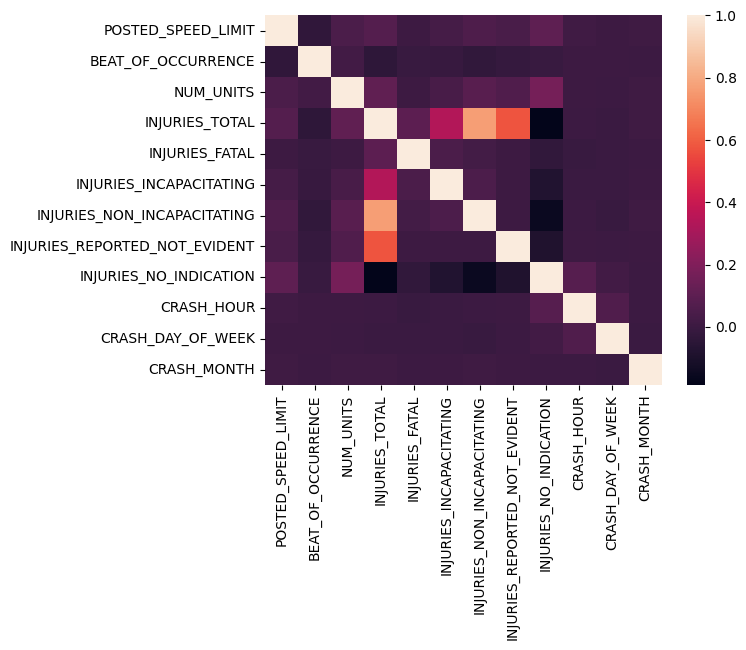

In [31]:
# Are certain factors correlated with severity of injuries?
sns.heatmap(crashes_[crashes_eda].corr());

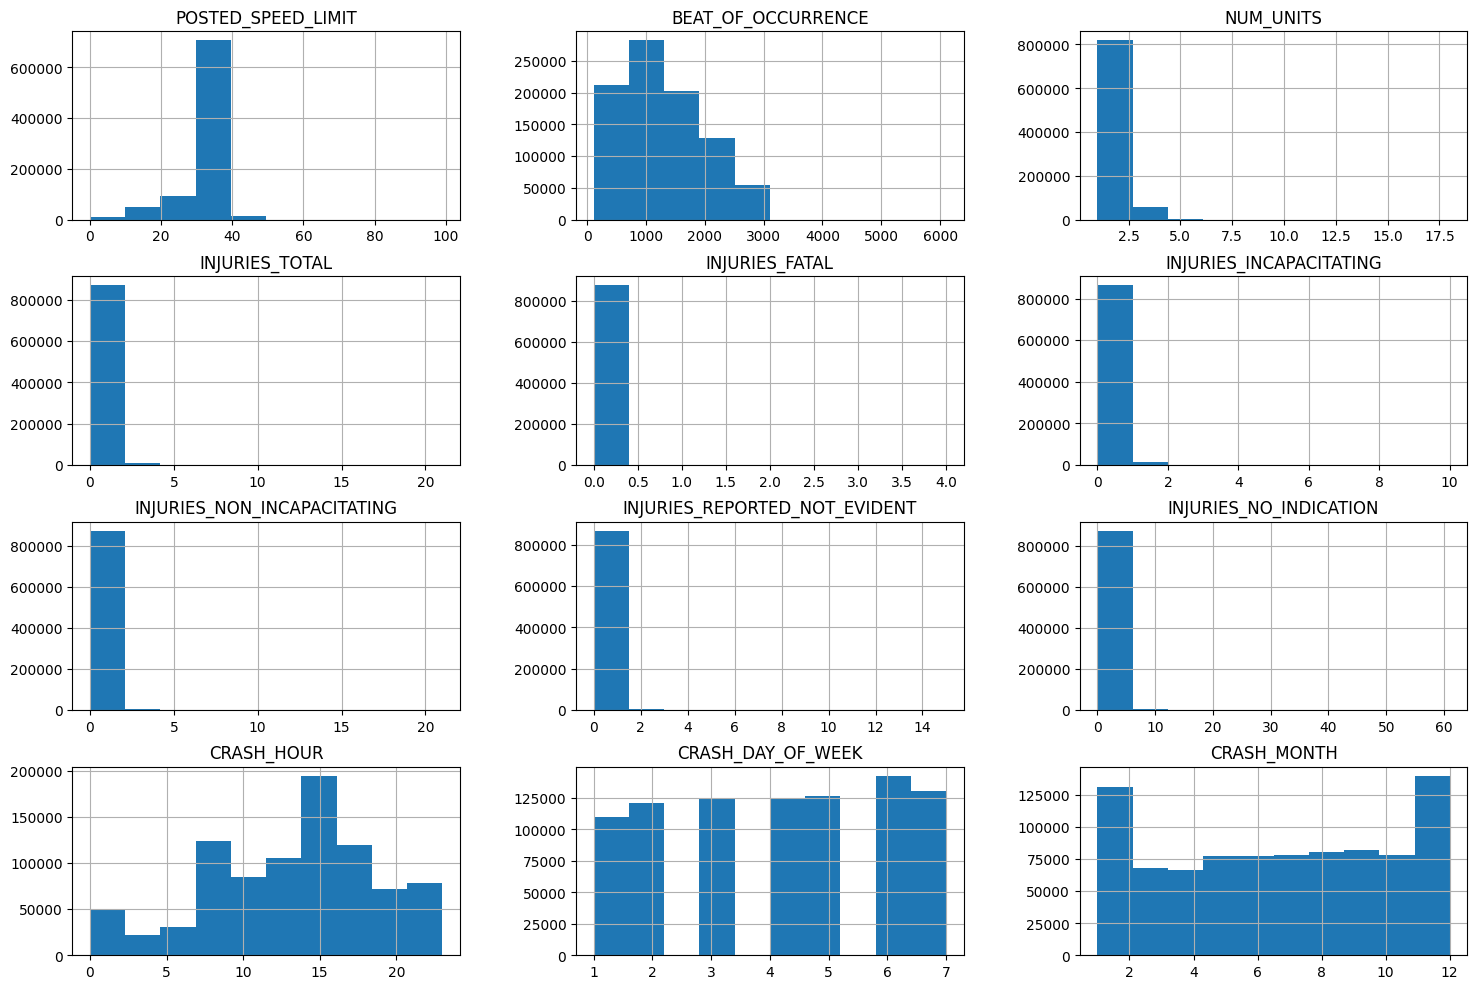

In [32]:
# Numeric variables
crashes_[crashes_eda].hist(figsize=(18, 12));

In [33]:
people_df.INJURY_CLASSIFICATION.value_counts()

INJURY_CLASSIFICATION
NO INDICATION OF INJURY     1761303
NONINCAPACITATING INJURY      95821
REPORTED, NOT EVIDENT         56333
INCAPACITATING INJURY         17549
FATAL                          1065
Name: count, dtype: int64

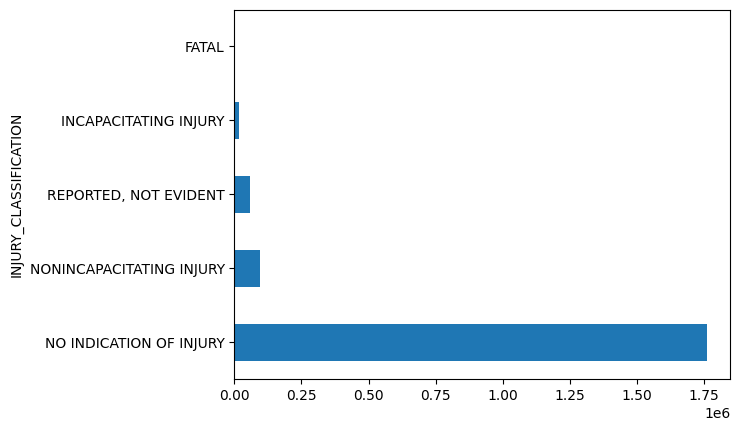

In [34]:
people_df.INJURY_CLASSIFICATION.value_counts().plot.barh();

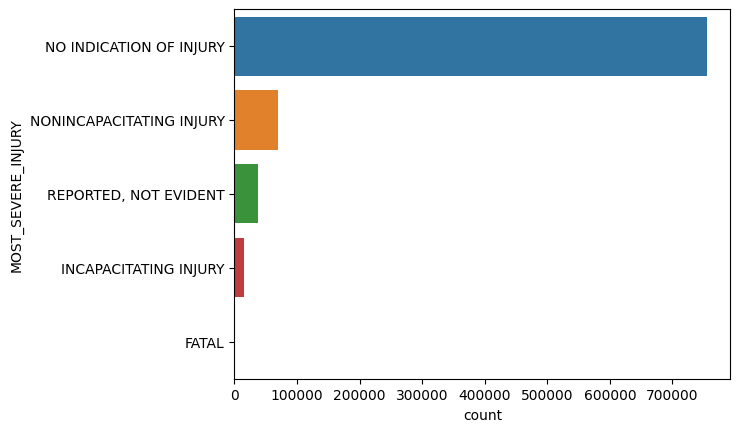

In [35]:
# Target values by crash
sns.barplot(y=crashes_.MOST_SEVERE_INJURY.value_counts().index, 
            x=crashes_.MOST_SEVERE_INJURY.value_counts(),
            orient='h');

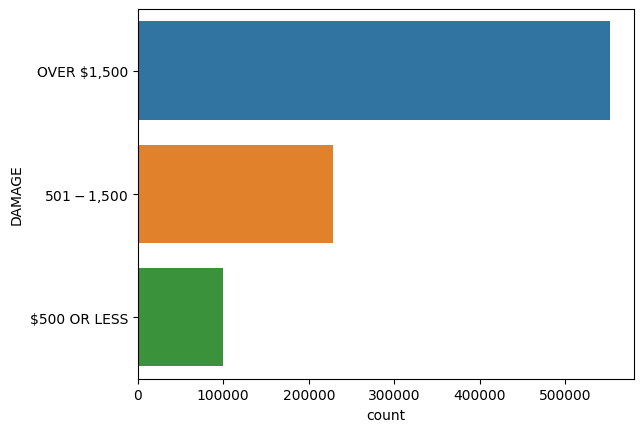

In [36]:
# Total damage in dollars
sns.barplot(y=crashes_.DAMAGE.value_counts().index, x=crashes_.DAMAGE.value_counts(), orient='h');

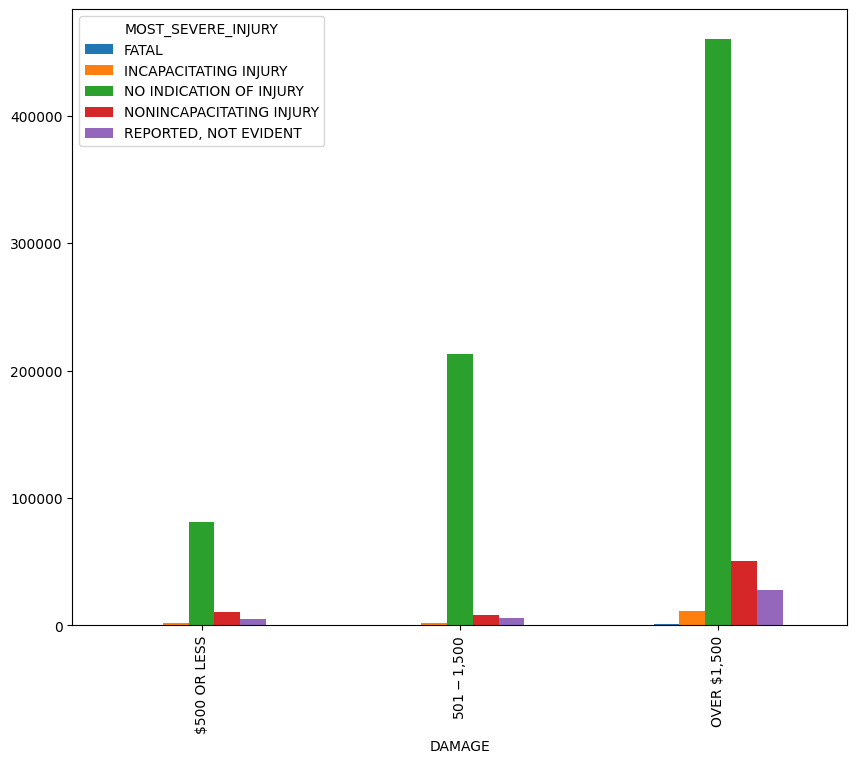

In [37]:
# Total damage disaggregated by most severe injury resulting from a crash
pd.crosstab(crashes_.DAMAGE, crashes_.MOST_SEVERE_INJURY).plot.bar(figsize=(10, 8));

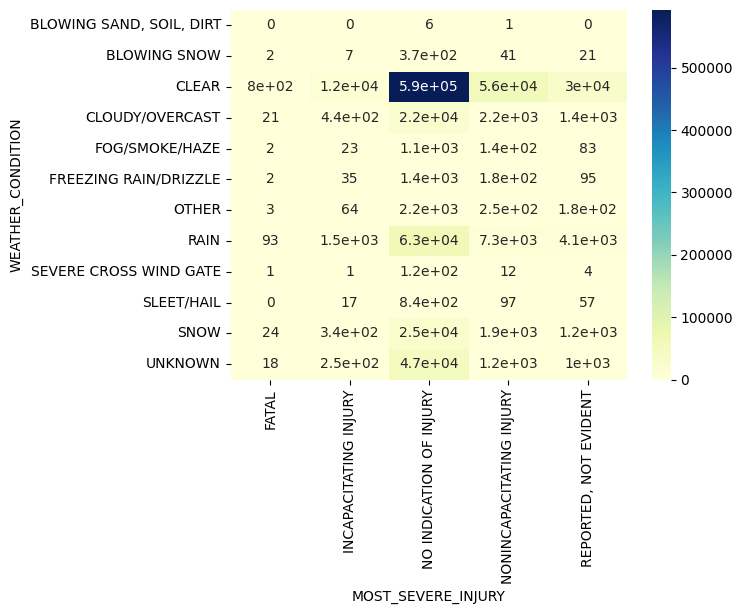

In [38]:
# How might weather affect the severity of injury resulting from a crash?
sns.heatmap(pd.crosstab(crashes_.WEATHER_CONDITION, 
                        crashes_.MOST_SEVERE_INJURY), 
            annot=True, cmap="YlGnBu");

In [39]:
people_ = people_df.drop(['PERSON_ID'], axis=1)

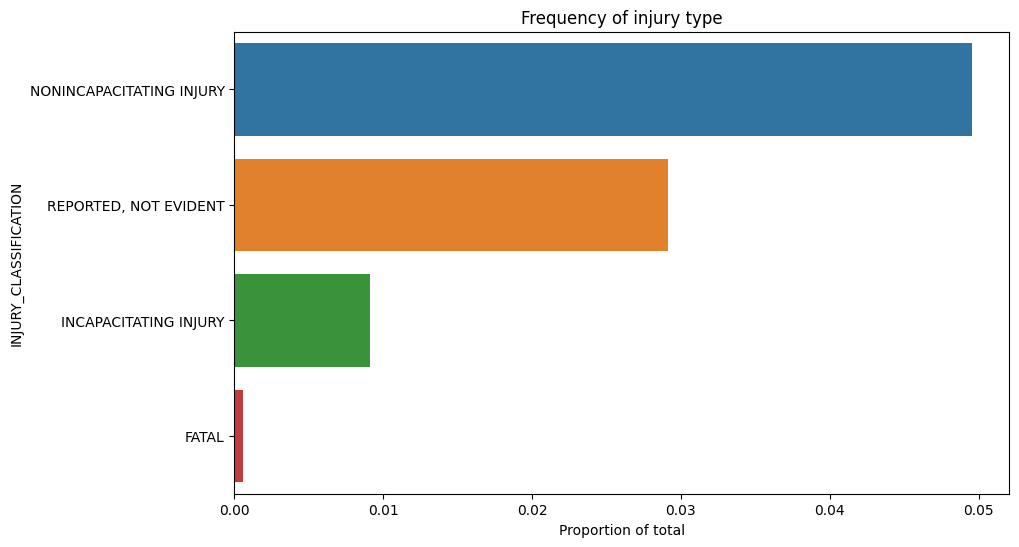

In [40]:
# Distribution of our target classes
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(y=people_df.INJURY_CLASSIFICATION.value_counts(normalize=True).drop('NO INDICATION OF INJURY').index, 
            x=people_df.INJURY_CLASSIFICATION.value_counts(normalize=True).drop('NO INDICATION OF INJURY'),
           orient='h', ax=ax)
plt.title('Frequency of injury type')
plt.xlabel('Proportion of total');

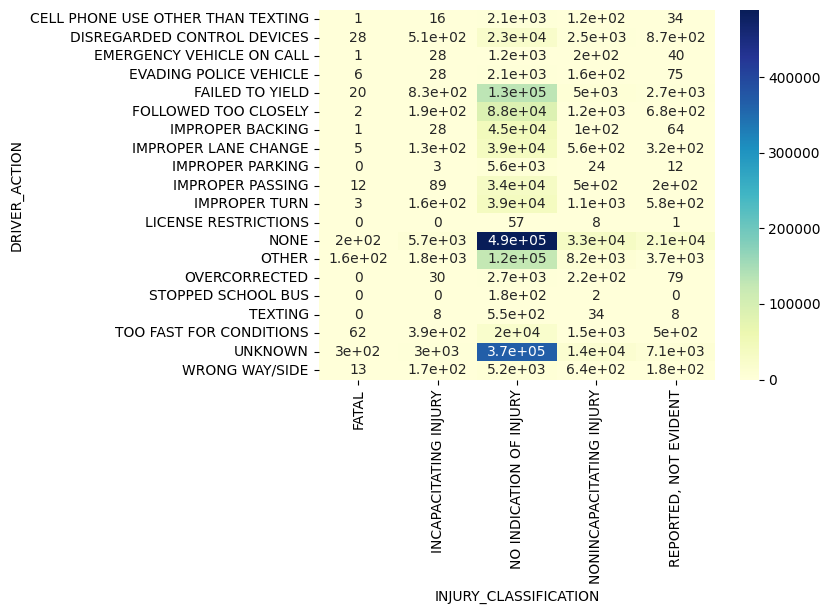

In [41]:
sns.heatmap(pd.crosstab(people_.DRIVER_ACTION, people_.INJURY_CLASSIFICATION),
            annot=True, cmap="YlGnBu");

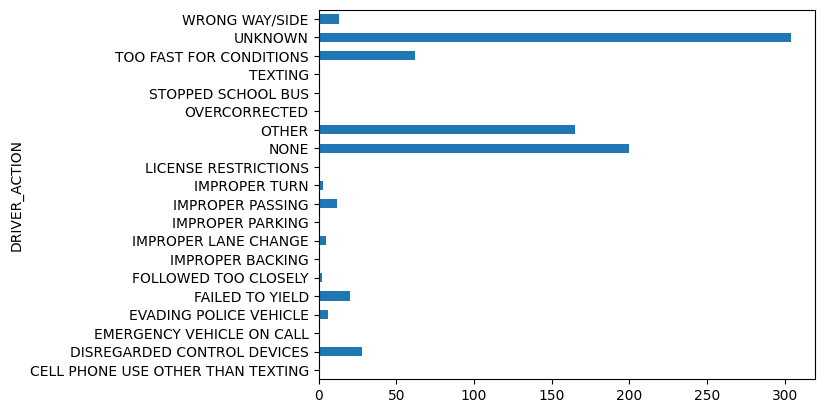

In [42]:
# Driver action with fatalities
pd.crosstab(people_.DRIVER_ACTION, people_.INJURY_CLASSIFICATION)['FATAL'].plot.barh();

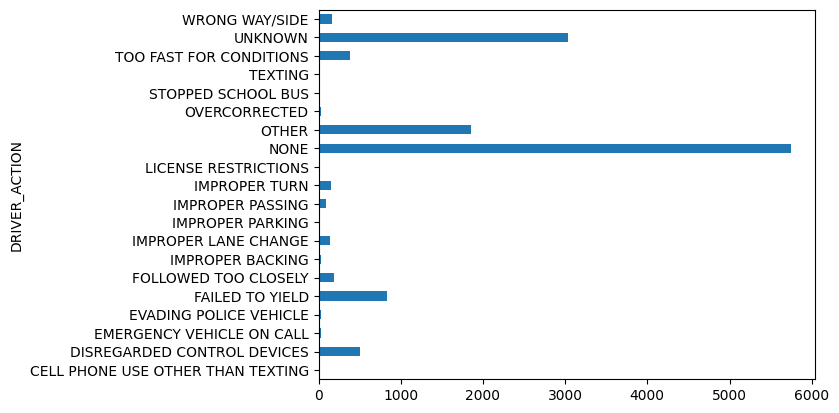

In [43]:
# Driver action with inapacitating injuries
pd.crosstab(people_.DRIVER_ACTION, people_.INJURY_CLASSIFICATION)['INCAPACITATING INJURY'].plot.barh();

In [44]:
# Distribution of breathalyzer tests
people_.BAC_RESULT.value_counts()

BAC_RESULT
TEST NOT OFFERED                   1516974
TEST REFUSED                         15854
TEST PERFORMED, RESULTS UNKNOWN       3660
TEST TAKEN                            2709
Name: count, dtype: int64

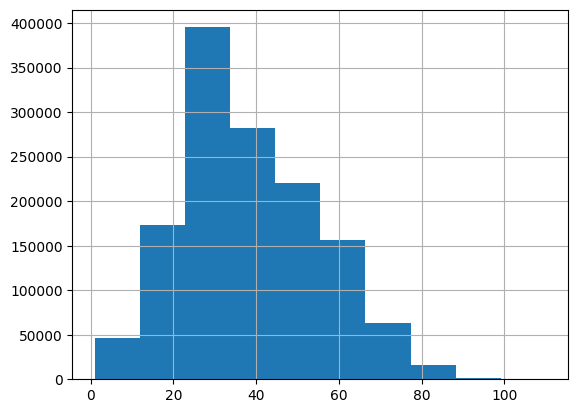

In [45]:
people_df[people_df['AGE'] > 0]['AGE'].hist();

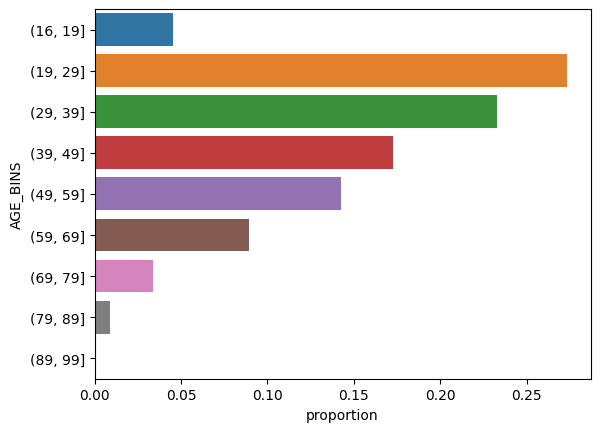

In [46]:
people_df['AGE_BINS'] = pd.cut(x=people_df['AGE'], bins=[16, 19, 29, 39, 49, 59, 69, 79, 89, 99])

sns.barplot(y=people_df.AGE_BINS.value_counts(normalize=True).index, x=people_df.AGE_BINS.value_counts(normalize=True),
           orient='h');

How does Age relate to injury?

In [47]:
pd.crosstab(people_df.AGE_BINS, people_df.INJURY_CLASSIFICATION)

INJURY_CLASSIFICATION,FATAL,INCAPACITATING INJURY,NO INDICATION OF INJURY,NONINCAPACITATING INJURY,"REPORTED, NOT EVIDENT"
AGE_BINS,,,,,
"(16, 19]",39,820,49638,4919,2492
"(19, 29]",217,4194,307914,24419,13398
"(29, 39]",190,3292,265783,18308,10878
"(39, 49]",125,2233,199413,12031,7679
"(49, 59]",111,2117,163026,10310,6772
"(59, 69]",88,1485,101631,6894,4128
"(69, 79]",52,652,38704,2608,1447
"(79, 89]",28,226,10310,826,408
"(89, 99]",3,20,1135,100,38


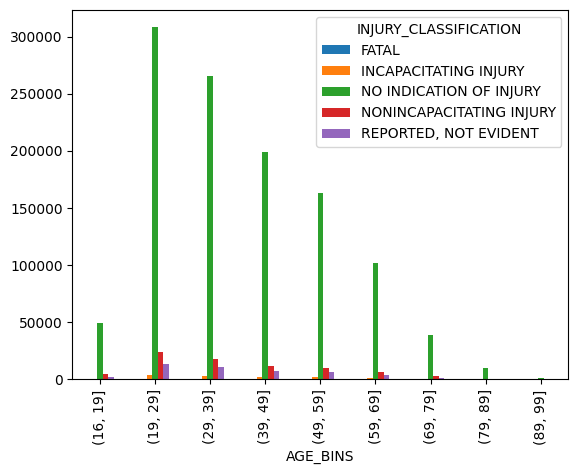

In [48]:
pd.crosstab(people_df.AGE_BINS, people_df.INJURY_CLASSIFICATION).plot.bar();

It appears as though people in their 20s are getting into a lot of wrecks, with all manner of outcomes, with the rate slowing with age. However, we can't conclude from this dataset alone that younger people are more likely to get into crashes. We would need to compare to general driver demographic data to see if this is proportional or not and calculate accident rates.

Our initial models predict that sex is a strong predictor for higher levels of injury/fatalities:

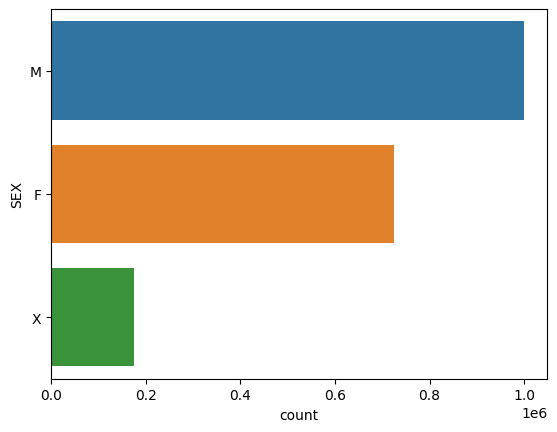

In [49]:
sns.barplot(y=people_df.SEX.value_counts().index, x=people_df.SEX.value_counts(),
           orient='h');

In [50]:
pd.crosstab(people_df.SEX, people_df.INJURY_CLASSIFICATION)

INJURY_CLASSIFICATION,FATAL,INCAPACITATING INJURY,NO INDICATION OF INJURY,NONINCAPACITATING INJURY,"REPORTED, NOT EVIDENT"
SEX,,,,,
F,272,7385,643620,45148,29209
M,761,9811,913433,48972,26048
X,14,104,174804,330,204


### Feature Selection

In [51]:
crashes_selected_df = crashes_df[['CRASH_RECORD_ID', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
                                 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 
                                 'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND',
                                 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 
                                  'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH']]

In [52]:
people_selected_df = people_df[['CRASH_RECORD_ID', 'PERSON_TYPE', 'AGE', 'SEX', 
                                'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'INJURY_CLASSIFICATION', 
                                'PHYSICAL_CONDITION', 'DRIVER_ACTION', 'DRIVER_VISION', 'BAC_RESULT']]

In [53]:
vehicle_selected_df = vehicle_df[['CRASH_RECORD_ID', 'UNIT_TYPE', 'VEHICLE_DEFECT', 
                                  'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEUVER']]


#### Merging all the data into one dataframe

Since we are focusing on predicting the causes that result to crashes, we will merge on `people_selected_df` in the left join with `crashes_selected_df` and `vehicle_selected_df` also on the left.

In [54]:
crashes_final_df = crashes_selected_df.merge(people_selected_df, on='CRASH_RECORD_ID', how='left')

crashes_final_df = crashes_final_df.merge(vehicle_selected_df, on='CRASH_RECORD_ID', how='left')

crashes_final_df.head()

,CRASH_RECORD_ID,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROADWAY_SURFACE_COND,...,PHYSICAL_CONDITION,DRIVER_ACTION,DRIVER_VISION,BAC_RESULT,UNIT_TYPE,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER
0,23a79931ef555d54118f64dc9be2cf2dbf59636ce253f7...,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DUSK,ANGLE,"FIVE POINT, OR MORE",STRAIGHT AND LEVEL,DRY,...,NORMAL,NONE,UNKNOWN,TEST NOT OFFERED,DRIVER,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD
1,23a79931ef555d54118f64dc9be2cf2dbf59636ce253f7...,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DUSK,ANGLE,"FIVE POINT, OR MORE",STRAIGHT AND LEVEL,DRY,...,NORMAL,NONE,UNKNOWN,TEST NOT OFFERED,DRIVER,UNKNOWN,OTHER,AMBULANCE,E,STRAIGHT AHEAD
2,23a79931ef555d54118f64dc9be2cf2dbf59636ce253f7...,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DUSK,ANGLE,"FIVE POINT, OR MORE",STRAIGHT AND LEVEL,DRY,...,NORMAL,EMERGENCY VEHICLE ON CALL,UNKNOWN,TEST NOT OFFERED,DRIVER,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD
3,23a79931ef555d54118f64dc9be2cf2dbf59636ce253f7...,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DUSK,ANGLE,"FIVE POINT, OR MORE",STRAIGHT AND LEVEL,DRY,...,NORMAL,EMERGENCY VEHICLE ON CALL,UNKNOWN,TEST NOT OFFERED,DRIVER,UNKNOWN,OTHER,AMBULANCE,E,STRAIGHT AHEAD
4,23a79931ef555d54118f64dc9be2cf2dbf59636ce253f7...,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DUSK,ANGLE,"FIVE POINT, OR MORE",STRAIGHT AND LEVEL,DRY,...,NaN,NaN,NaN,NaN,DRIVER,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD


In [55]:
missing_values_summary(crashes_final_df)

,Missing Values,Percentage
AGE,1178123,28.996382
DRIVER_VISION,842370,20.732710
DRIVER_ACTION,841065,20.700591
BAC_RESULT,838798,20.644794
PHYSICAL_CONDITION,838671,20.641669
VEHICLE_DEFECT,96451,2.373886
VEHICLE_TYPE,96451,2.373886
TRAVEL_DIRECTION,96451,2.373886
MANEUVER,96451,2.373886
VEHICLE_USE,96451,2.373886


In [56]:
crashes_final_df = crashes_final_df.dropna()

In [57]:
crashes_final_df.shape

(2274523, 32)

In [58]:
crashes_final_df.columns

Index(['CRASH_RECORD_ID', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE',
       'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ALIGNMENT',
       'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE',
       'SEC_CONTRIBUTORY_CAUSE', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK',
       'CRASH_MONTH', 'PERSON_TYPE', 'AGE', 'SEX', 'SAFETY_EQUIPMENT',
       'AIRBAG_DEPLOYED', 'INJURY_CLASSIFICATION', 'PHYSICAL_CONDITION',
       'DRIVER_ACTION', 'DRIVER_VISION', 'BAC_RESULT', 'UNIT_TYPE',
       'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION',
       'MANEUVER'],
      dtype='object')

In [59]:
crashes_final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2274523 entries, 0 to 4062995
Data columns (total 32 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   CRASH_RECORD_ID          object 
 1   POSTED_SPEED_LIMIT       int64  
 2   TRAFFIC_CONTROL_DEVICE   object 
 3   DEVICE_CONDITION         object 
 4   WEATHER_CONDITION        object 
 5   LIGHTING_CONDITION       object 
 6   FIRST_CRASH_TYPE         object 
 7   TRAFFICWAY_TYPE          object 
 8   ALIGNMENT                object 
 9   ROADWAY_SURFACE_COND     object 
 10  ROAD_DEFECT              object 
 11  PRIM_CONTRIBUTORY_CAUSE  object 
 12  SEC_CONTRIBUTORY_CAUSE   object 
 13  CRASH_HOUR               int64  
 14  CRASH_DAY_OF_WEEK        int64  
 15  CRASH_MONTH              int64  
 16  PERSON_TYPE              object 
 17  AGE                      float64
 18  SEX                      object 
 19  SAFETY_EQUIPMENT         object 
 20  AIRBAG_DEPLOYED          object 
 21  INJURY_CLASSI

In [60]:
crashes_final_df.isna().sum()

CRASH_RECORD_ID            0
POSTED_SPEED_LIMIT         0
TRAFFIC_CONTROL_DEVICE     0
DEVICE_CONDITION           0
WEATHER_CONDITION          0
LIGHTING_CONDITION         0
FIRST_CRASH_TYPE           0
TRAFFICWAY_TYPE            0
ALIGNMENT                  0
ROADWAY_SURFACE_COND       0
ROAD_DEFECT                0
PRIM_CONTRIBUTORY_CAUSE    0
SEC_CONTRIBUTORY_CAUSE     0
CRASH_HOUR                 0
CRASH_DAY_OF_WEEK          0
CRASH_MONTH                0
PERSON_TYPE                0
AGE                        0
SEX                        0
SAFETY_EQUIPMENT           0
AIRBAG_DEPLOYED            0
INJURY_CLASSIFICATION      0
PHYSICAL_CONDITION         0
DRIVER_ACTION              0
DRIVER_VISION              0
BAC_RESULT                 0
UNIT_TYPE                  0
VEHICLE_DEFECT             0
VEHICLE_TYPE               0
VEHICLE_USE                0
TRAVEL_DIRECTION           0
MANEUVER                   0
dtype: int64

Checking for duplicates

In [61]:
duplicate_rows = crashes_final_df[crashes_final_df.duplicated()]
print(duplicate_rows)

                                           CRASH_RECORD_ID  \
131      4a1f7a24129e5e1d4a7a2fd44ab6f8822a20bcdb2f627f...   
132      4a1f7a24129e5e1d4a7a2fd44ab6f8822a20bcdb2f627f...   
134      4a1f7a24129e5e1d4a7a2fd44ab6f8822a20bcdb2f627f...   
135      4a1f7a24129e5e1d4a7a2fd44ab6f8822a20bcdb2f627f...   
137      4a1f7a24129e5e1d4a7a2fd44ab6f8822a20bcdb2f627f...   
...                                                    ...   
4062933  61c8dcd63fae60613bc9ec526fa901420cbe99a6d35840...   
4062934  61c8dcd63fae60613bc9ec526fa901420cbe99a6d35840...   
4062949  cb0ca76762ca65feacb1f6513312f96f2a05629bd8a866...   
4062955  cb0ca76762ca65feacb1f6513312f96f2a05629bd8a866...   
4062957  cb0ca76762ca65feacb1f6513312f96f2a05629bd8a866...   

         POSTED_SPEED_LIMIT TRAFFIC_CONTROL_DEVICE      DEVICE_CONDITION  \
131                      30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
132                      30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
134                      30

From the above output, there are 158574 rows that are duplicates

Remove all the duplicates from the dataset

In [62]:
# Remove all duplicates based on all columns
def remove_all_duplicates(df):
    original_shape = df.shape
    df_no_duplicates = df.drop_duplicates()
    removed_count = original_shape[0] - df_no_duplicates.shape[0]
    
    print(f"Original number of rows: {original_shape[0]}")
    print(f"Number of rows after removing duplicates: {df_no_duplicates.shape[0]}")
    print(f"Number of duplicate rows removed: {removed_count}")
    
    return df_no_duplicates

In [63]:
crashes_final_df = remove_all_duplicates(crashes_final_df)

Original number of rows: 2274523
Number of rows after removing duplicates: 2115949
Number of duplicate rows removed: 158574


In [64]:
crashes_final_df.duplicated().sum()

0

There are now no duplicates in our dataset. The number of duplicates were found to be 158574. After removal of the duplicates, the number of rows reduced to 2115949 from 2274523

We now going to analyze the column values of our dataset

In [65]:
def analyze_column_values(df):
    for column in df.columns:
        unique_values = df[column].unique()
        n_unique = len(unique_values)
        
        print(f"\n{'='*50}")
        print(f"Column: {column}")
        print(f"Number of unique values: {n_unique}")
        print(f"Data type: {df[column].dtype}")
        
        # For numerical columns, show statistics
        if np.issubdtype(df[column].dtype, np.number):
            print(f"Min: {df[column].min()}")
            print(f"Max: {df[column].max()}")
            print(f"Mean: {df[column].mean():.2f}")
            print("Sample values:", unique_values[:5] if n_unique > 5 else unique_values)
        
        # For categorical/object columns
        else:
            # If too many unique values, show sample and value counts
            if n_unique > 20:
                print("Top 10 most common values:")
                print(df[column].value_counts().nlargest(10))
                print(f"\nSample values: {unique_values[:5]}")
            else:
                print("All unique values:")
                for value in unique_values:
                    count = df[column].value_counts()[value]
                    print(f"- {value}: {count} occurrences")

In [66]:
def get_unique_crash_records(df):

    # Count duplicates before removal
    duplicate_count = df[df.duplicated(subset=['CRASH_RECORD_ID'])]['CRASH_RECORD_ID'].count()
    
    # Keep only the first occurrence of each CRASH_RECORD_ID
    df_unique = df.drop_duplicates(subset=['CRASH_RECORD_ID'], keep='first')
    
    return df_unique

In [67]:
crashes_final_df = get_unique_crash_records(crashes_final_df)

In [68]:
crashes_final_df.shape

(700886, 32)

In [69]:
analyze_column_values(crashes_final_df)


Column: CRASH_RECORD_ID
Number of unique values: 700886
Data type: object
Top 10 most common values:
CRASH_RECORD_ID
37b7acd5f2db6728ca4ac0d7e4217f78b6703f769754b495c437ace10d472977fe4ad4973167dd364031c0641830c0d163bd382d7c6927e2669619ce77051f65    1
23a79931ef555d54118f64dc9be2cf2dbf59636ce253f7a1179c4a1c091442a6eeab8352220c7c56ca1ff7c4b4b0fc345c74e3e85ecb9d43deeb66b5f803d4a0    1
2675c13fd0f474d730a5b780968b3cafc7c12d7adb661fa8a3093c0658d5a0d51b720fc9e031a1ddd83c761a8e2aa7283573557db246f4c9e956aaa58719cacf    1
7ebf015016f83d09b321afd671a836d6b148330535d5df85f232edb575a7f2a42e61b9747067e89c4e7a73e69efc819c9003ed153e19765f2ecc6f7b2421c98d    1
6c1659069e9c6285a650e70d6f9b574ed5f64c12888479093dfeef179c0344ec6d2057eae224b5c0d5dfc278c0a237f8c22543f07fdef2e4a95a3849871c9345    1
004cd14d0303a9163aad69a2d7f341b7da2a8572b2ab3378594bfae8ac53dcb604dd8d414f93c290b55862f9f2517ad32e6209cbc8034c2e26eb3c2bc9724390    1
359bf9f5872d646bb63576e55b1e0b480dc93c2b935ab571dc26ddb48b7a328fbfe130ae70bbff

In [70]:
# Statistical summary
crashes_final_df.describe()

,POSTED_SPEED_LIMIT,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,AGE
count,700886.000000,700886.000000,700886.000000,700886.000000,700886.000000
mean,28.871013,13.377832,4.144618,6.650432,39.753371
std,5.753084,5.378098,1.958233,3.367543,16.209309
min,0.000000,0.000000,1.000000,1.000000,-49.000000
25%,30.000000,10.000000,2.000000,4.000000,27.000000
50%,30.000000,14.000000,4.000000,7.000000,37.000000
75%,30.000000,17.000000,6.000000,9.000000,51.000000
max,99.000000,23.000000,7.000000,12.000000,110.000000


### Data Preprocessing

MANEUVER

In [71]:
# Define the categories and corresponding maneuvers
maneuver_categories = {
    'Normal Driving': [
        'STRAIGHT AHEAD',
        'TURNING LEFT',
        'TURNING RIGHT',
        'TURNING ON RED'
    ],
    'Traffic Interactions': [
        'SLOW/STOP IN TRAFFIC',
        'ENTERING TRAFFIC LANE FROM PARKING',
        'MERGING',
        'PASSING/OVERTAKING',
        'CHANGING LANES',
        'AVOIDING VEHICLES/OBJECTS',
        'DRIVING WRONG WAY'
    ],
    'Parking and Stationary Actions': [
        'PARKED',
        'PARKED IN TRAFFIC LANE',
        'LEAVING TRAFFIC LANE TO PARK',
        'SLOW/STOP - LOAD/UNLOAD',
        'DRIVERLESS'
    ],
    'Reversal and Backing': [
        'BACKING',
        'ENTER FROM DRIVE/ALLEY',
        'U-TURN'
    ],
    'Unknown/Other': [
        'UNKNOWN/NA',
        'OTHER',
        'SLOW/STOP - LEFT TURN',
        'SLOW/STOP - RIGHT TURN',
        'SLOW/STOP - LOAD/UNLOAD',
        'SKIDDING/CONTROL LOSS',
        'STARTING IN TRAFFIC',
        'NEGOTIATING A CURVE',
        'DIVERGING',
        'DISABLED'
    ]
}

# Create a new column in crashes_final_df to categorize maneuvers
def categorize_maneuver(maneuver):
    for category, maneuvers in maneuver_categories.items():
        if maneuver in maneuvers:
            return category

# Apply the categorization function to the 'MANEUVER' column
crashes_final_df['MANEUVER_CATEGORY'] = crashes_final_df['MANEUVER'].apply(categorize_maneuver)

VEHICLE_USE

In [72]:
# Define the categories and corresponding vehicle uses
vehicle_use_categories = {
    'Personal Use': [
        'PERSONAL'
    ],
    'Unknown': [
        'UNKNOWN/NA'
    ],
    'Commercial Use': [
        'COMMERCIAL - SINGLE UNIT',
        'COMMERCIAL - MULTI-UNIT',
        'TAXI/FOR HIRE',
        'RIDESHARE SERVICE',
        'TOW TRUCK',
        'AMBULANCE',
        'POLICE',
        'FIRE',
        'CONSTRUCTION/MAINTENANCE',
        'SCHOOL BUS',
        'OTHER TRANSIT'
    ],
    'Public Transportation': [
        'MASS TRANSIT',
        'CTA'
    ],
    'Recreational and Special Use': [
        'CAMPER/RV - SINGLE UNIT',
        'CAMPER/RV - TOWED/MULTI-UNIT',
        'AGRICULTURE',
        'LAWN CARE/LANDSCAPING',
        'DRIVER EDUCATION',
        'STATE OWNED',
        'NOT IN USE',
        'OTHER'
    ]
}

# Create a new column in crashes_final_df to categorize vehicle uses
def categorize_vehicle_use(vehicle_use):
    for category, uses in vehicle_use_categories.items():
        if vehicle_use in uses:
            return category

# Apply the categorization function to the 'VEHICLE_USE' column
crashes_final_df['VEHICLE_USE_CATEGORY'] = crashes_final_df['VEHICLE_USE'].apply(categorize_vehicle_use)

VEHICLE_TYPE

In [73]:
# Define the categories and corresponding vehicle types
vehicle_type_categories = {
    'Passenger Vehicles': [
        'PASSENGER',
        'VAN/MINI-VAN',
        'SPORT UTILITY VEHICLE (SUV)'
    ],
    'Trucks': [
        'PICKUP',
        'TRUCK - SINGLE UNIT',
        'SINGLE UNIT TRUCK WITH TRAILER',
        'TRACTOR W/ SEMI-TRAILER',
        'TRACTOR W/O SEMI-TRAILER'
    ],
    'Buses': [
        'BUS OVER 15 PASS.',
        'BUS UP TO 15 PASS.'
    ],
    'Motorcycles and Similar': [
        'MOTORCYCLE (OVER 150CC)',
        'MOPED OR MOTORIZED BICYCLE',
        '3-WHEELED MOTORCYCLE (2 REAR WHEELS)',
        'MOTOR DRIVEN CYCLE',
        'AUTOCYCLE',
        'ALL-TERRAIN VEHICLE (ATV)',
        'RECREATIONAL OFF-HIGHWAY VEHICLE (ROV)'
    ],
    'Unknown/Other': [
        'UNKNOWN/NA',
        'OTHER'
    ]
}

# Create a new column in crashes_final_df to categorize vehicle types
def categorize_vehicle_type(vehicle):
    for category, types in vehicle_type_categories.items():
        if vehicle in types:
            return category

# Apply the categorization function to the 'VEHICLE_TYPE' column
crashes_final_df['VEHICLE_TYPE_CATEGORY'] = crashes_final_df['VEHICLE_TYPE'].apply(categorize_vehicle_type)


VEHICLE_DEFECT

In [74]:
# Define the categories and corresponding vehicle defects
vehicle_defect_categories = {
    'No Defect': [
        'NONE'
    ],
    'Unknown': [
        'UNKNOWN'
    ],
    'Braking System Issues': [
        'BRAKES'
    ],
    'Tire and Wheel Issues': [
        'TIRES',
        'WHEELS',
        'STEERING',
        'SUSPENSION'
    ],
    'Mechanical/System Issues': [
        'ENGINE/MOTOR',
        'FUEL SYSTEM',
        'WINDOWS',
        'LIGHTS',
        'CARGO',
        'SIGNALS',
        'RESTRAINT SYSTEM',
        'TRAILER COUPLING',
        'EXHAUST',
        'OTHER'
    ]
}

# Create a new column in crashes_final_df to categorize vehicle defects
def categorize_vehicle_defect(defect):
    for category, defects in vehicle_defect_categories.items():
        if defect in defects:
            return category
        
# Apply the categorization function to the 'VEHICLE_DEFECT' column
crashes_final_df['VEHICLE_DEFECT_CATEGORY'] = crashes_final_df['VEHICLE_DEFECT'].apply(categorize_vehicle_defect)


DRIVER_VISION

In [75]:
# Define the categories and corresponding driver vision conditions
driver_vision_categories = {
    'Normal Vision': [
        'NOT OBSCURED'
    ],
    'Unknown': [
        'UNKNOWN'
    ],
    'Obstructions': [
        'OTHER',
        'MOVING VEHICLES',
        'PARKED VEHICLES',
        'TREES, PLANTS',
        'BUILDINGS',
        'SIGNBOARD'
    ],
    'Environmental Conditions': [
        'WINDSHIELD (WATER/ICE)',
        'BLINDED - SUNLIGHT',
        'BLINDED - HEADLIGHTS',
        'BLOWING MATERIALS'
    ],
    'Topographical Factors': [
        'HILLCREST',
        'EMBANKMENT'
    ]
}

# Create a new column in crashes_final_df to categorize driver vision
def categorize_driver_vision(vision):
    for category, visions in driver_vision_categories.items():
        if vision in visions:
            return category

# Apply the categorization function to the 'DRIVER_VISION' column
crashes_final_df['DRIVER_VISION_CATEGORY'] = crashes_final_df['DRIVER_VISION'].apply(categorize_driver_vision)


DRIVER_ACTION

In [76]:
# Define the categories and corresponding driver actions
driver_action_categories = {
    'Normal Behavior': [
        'NONE'
    ],
    'Unknown': [
        'UNKNOWN'
    ],
    'Failure to Yield/Traffic Violations': [
        'FAILED TO YIELD',
        'DISREGARDED CONTROL DEVICES',
        'STOPPED SCHOOL BUS',
        'LICENSE RESTRICTIONS',
        'OTHER'
    ],
    'Aggressive/Improper Driving': [
        'FOLLOWED TOO CLOSELY',
        'IMPROPER TURN',
        'IMPROPER BACKING',
        'IMPROPER LANE CHANGE',
        'IMPROPER PASSING',
        'TOO FAST FOR CONDITIONS',
        'IMPROPER PARKING',
        'WRONG WAY/SIDE',
        'OVERCORRECTED'
    ],
    'Distracted Driving': [
        'CELL PHONE USE OTHER THAN TEXTING',
        'TEXTING',
        'EVADING POLICE VEHICLE',
        'EMERGENCY VEHICLE ON CALL'
    ]
}

# Create a new column in crashes_final_df to categorize driver actions
def categorize_driver_action(action):
    for category, actions in driver_action_categories.items():
        if action in actions:
            return category

# Apply the categorization function to the 'DRIVER_ACTION' column
crashes_final_df['DRIVER_ACTION_CATEGORY'] = crashes_final_df['DRIVER_ACTION'].apply(categorize_driver_action)

PHYSICAL_CONDITION

In [77]:
# Define the categories and corresponding physical conditions
physical_condition_categories = {
    'Normal': [
        'NORMAL'
    ],
    'Impaired': [
        'IMPAIRED - ALCOHOL',
        'IMPAIRED - DRUGS',
        'IMPAIRED - ALCOHOL AND DRUGS',
        'MEDICATED'
    ],
    'Fatigued': [
        'FATIGUED/ASLEEP'
    ],
    'Emotional': [
        'EMOTIONAL'
    ],
    'Unknown': [
        'UNKNOWN'
    ],
    'Other': [
        'OTHER',
        'REMOVED BY EMS',
        'ILLNESS/FAINTED',
        'HAD BEEN DRINKING'
    ]
}

# Create a new column in crashes_final_df to categorize physical condition
def categorize_physical_condition(condition):
    for category, conditions in physical_condition_categories.items():
        if condition in conditions:
            return category

# Apply the categorization function to the 'PHYSICAL_CONDITION' column
crashes_final_df['PHYSICAL_CONDITION_CATEGORY'] = crashes_final_df['PHYSICAL_CONDITION'].apply(categorize_physical_condition)

AIRBAG_DEPLOYED

In [78]:
# Define the categories and corresponding airbag deployment statuses
airbag_deployment_categories = {
    'Not Deployed': [
        'DID NOT DEPLOY',
        'NOT APPLICABLE'
    ],
    'Unknown': [
        'DEPLOYMENT UNKNOWN'
    ],
    'Deployed': [
        'DEPLOYED, FRONT',
        'DEPLOYED, COMBINATION',
        'DEPLOYED, SIDE',
        'DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)'
    ]
}

# Create a new column in crashes_final_df to categorize airbag deployment
def categorize_airbag_deployment(deployment):
    for category, statuses in airbag_deployment_categories.items():
        if deployment in statuses:
            return category

# Apply the categorization function to the 'AIRBAG_DEPLOYED' column
crashes_final_df['AIRBAG_DEPLOYMENT_CATEGORY'] = crashes_final_df['AIRBAG_DEPLOYED'].apply(categorize_airbag_deployment)

SAFETY_EQUIPMENT

In [79]:
# Define the categories and corresponding safety equipment usage
safety_equipment_categories = {
    'Used': [
        'SAFETY BELT USED',
        'DOT COMPLIANT MOTORCYCLE HELMET',
        'HELMET USED',
        'SHOULD/LAP BELT USED IMPROPERLY',
        'CHILD RESTRAINT USED'
    ],
    'Not Used': [
        'SAFETY BELT NOT USED',
        'HELMET NOT USED',
        'NOT DOT COMPLIANT MOTORCYCLE HELMET',
        'WHEELCHAIR',
        'STRETCHER'
    ],
    'Unknown': [
        'USAGE UNKNOWN',
        'NONE PRESENT'
    ]
}

# Create a new column in crashes_final_df to categorize safety equipment usage
def categorize_safety_equipment(equipment):
    for category, items in safety_equipment_categories.items():
        if equipment in items:
            return category

# Apply the categorization function to the 'SAFETY_EQUIPMENT' column
crashes_final_df['SAFETY_EQUIPMENT_CATEGORY'] = crashes_final_df['SAFETY_EQUIPMENT'].apply(categorize_safety_equipment)

SEC_CONTRIBUTORY_CAUSE

In [80]:
# Define the categories and corresponding contributory causes for SEC_CONTRIBUTORY_CAUSE
sec_contributory_cause_categories = {
    'Driver Error': [
        'FAILING TO REDUCE SPEED TO AVOID CRASH',
        'FAILING TO YIELD RIGHT-OF-WAY',
        'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
        'FOLLOWING TOO CLOSELY',
        'IMPROPER OVERTAKING/PASSING',
        'IMPROPER LANE USAGE',
        'IMPROPER TURNING/NO SIGNAL',
        'IMPROPER BACKING',
        'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
        'DISREGARDING TRAFFIC SIGNALS',
        'DISREGARDING STOP SIGN',
        'DRIVING ON WRONG SIDE/WRONG WAY',
        'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)',
        'DISTRACTION - FROM INSIDE VEHICLE',
        'DISTRACTION - FROM OUTSIDE VEHICLE',
        'CELL PHONE USE OTHER THAN TEXTING',
        'TEXTING',
        'DISREGARDING OTHER TRAFFIC SIGNS',
        'DISREGARDING ROAD MARKINGS',
        'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)',
        'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',
        'TURNING RIGHT ON RED',
        'BICYCLE ADVANCING LEGALLY ON RED LIGHT',
        'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT',
        'PASSING STOPPED SCHOOL BUS'
    ],
    'Vehicle Conditions': [
        'EQUIPMENT - VEHICLE CONDITION',
        'PHYSICAL CONDITION OF DRIVER',
        'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)'
    ],
    'Environmental Factors / Other': [
        'NOT APPLICABLE',
        'UNABLE TO DETERMINE',
        'WEATHER',
        'ROAD ENGINEERING/SURFACE/MARKING DEFECTS',
        'ROAD CONSTRUCTION/MAINTENANCE',
        'ANIMAL',
        'RELATED TO BUS STOP',
        'UNKNOWN'  # If any additional unspecified cause needs to be categorized
    ]
}

# Create a new column in crashes_final_df to categorize 'SEC_CONTRIBUTORY_CAUSE'
def categorize_sec_contributory_cause(cause):
    for category, causes in sec_contributory_cause_categories.items():
        if cause in causes:
            return category
        
# Apply the categorization function to the 'SEC_CONTRIBUTORY_CAUSE' column
crashes_final_df['SEC_CONTRIBUTORY_CAUSE_CATEGORY'] = crashes_final_df['SEC_CONTRIBUTORY_CAUSE'].apply(categorize_sec_contributory_cause)

PRIM_CONTRIBUTORY_CAUSE

In [81]:
# Define the categories and corresponding contributory causes
contributory_cause_categories = {
    'Driver Error': [
        'FAILING TO YIELD RIGHT-OF-WAY',
        'FOLLOWING TOO CLOSELY',
        'IMPROPER OVERTAKING/PASSING',
        'FAILING TO REDUCE SPEED TO AVOID CRASH',
        'IMPROPER TURNING/NO SIGNAL',
        'IMPROPER LANE USAGE',
        'IMPROPER BACKING',
        'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
        'DISREGARDING TRAFFIC SIGNALS',
        'DISREGARDING STOP SIGN',
        'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
        'DISTRACTION - FROM INSIDE VEHICLE',
        'DISTRACTION - FROM OUTSIDE VEHICLE',
        'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)',
        'DRIVING ON WRONG SIDE/WRONG WAY',
        'CELL PHONE USE OTHER THAN TEXTING',
        'TEXTING',
        'DISREGARDING YIELD SIGN',
        'PASSING STOPPED SCHOOL BUS',
        'OBSTRUCTED CROSSWALKS',
        'BICYCLE ADVANCING LEGALLY ON RED LIGHT',
        'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT'
    ],
    'Vehicle Conditions': [
        'EQUIPMENT - VEHICLE CONDITION',
        'PHYSICAL CONDITION OF DRIVER',
        'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)'
    ],
    'Environmental Factors / Other': [
        'UNABLE TO DETERMINE',
        'NOT APPLICABLE',
        'WEATHER',
        'ROAD ENGINEERING/SURFACE/MARKING DEFECTS',
        'DISREGARDING OTHER TRAFFIC SIGNS',
        'ROAD CONSTRUCTION/MAINTENANCE',
        'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',
        'EXCEEDING AUTHORIZED SPEED LIMIT',
        'EXCEEDING SAFE SPEED FOR CONDITIONS',
        'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)',
        'ANIMAL',
        'TURNING RIGHT ON RED',
        'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)',
        'RELATED TO BUS STOP',
        'UNKNOWN' 
    ]
}

# Create a new column in crashes_final_df to categorize 'PRIM_CONTRIBUTORY_CAUSE'
def categorize_contributory_cause(cause):
    for category, causes in contributory_cause_categories.items():
        if cause in causes:
            return category

# Apply the categorization function to the 'PRIM_CONTRIBUTORY_CAUSE' column
crashes_final_df['PRIM_CONTRIBUTORY_CAUSE_CATEGORY'] = crashes_final_df['PRIM_CONTRIBUTORY_CAUSE'].apply(categorize_contributory_cause)

ROAD_DEFECT

In [82]:
# Define the categories and corresponding road defects
road_defect_categories = {
    'No Defects': ['NO DEFECTS'],
    'Minor Defects': ['RUT, HOLES', 'OTHER', 'WORN SURFACE', 'SHOULDER DEFECT', 'DEBRIS ON ROADWAY'],
    'Major Defects / Unknown': ['UNKNOWN']
}

# Create a new column in crashes_final_df to categorize 'ROAD_DEFECT'
def categorize_road_defect(defect):
    for category, defects in road_defect_categories.items():
        if defect in defects:
            return category

# Apply the categorization function to the 'ROAD_DEFECT' column
crashes_final_df['ROAD_DEFECT_CATEGORY'] = crashes_final_df['ROAD_DEFECT'].apply(categorize_road_defect)

ROADWAY_SURFACE_COND

In [83]:
# Define the categories and corresponding roadway surface conditions
roadway_surface_categories = {
    'Normal/Dry Conditions': ['DRY'],
    'Wet/Slippery Conditions': ['WET', 'SNOW OR SLUSH', 'ICE', 'SAND, MUD, DIRT'],
    'Unknown/Other Conditions': ['UNKNOWN', 'OTHER']
}

# Create a new column in crashes_final_df to categorize 'ROADWAY_SURFACE_COND'
def categorize_roadway_surface(condition):
    for category, conditions in roadway_surface_categories.items():
        if condition in conditions:
            return category

# Apply the categorization function to the 'ROADWAY_SURFACE_COND' column
crashes_final_df['ROADWAY_SURFACE_CATEGORY'] = crashes_final_df['ROADWAY_SURFACE_COND'].apply(categorize_roadway_surface)

ALIGNMENT

In [84]:
# Define the categories and corresponding alignment types
alignment_categories = {
    'Straight Roads': ['STRAIGHT AND LEVEL', 'STRAIGHT ON GRADE'],
    'Curved Roads': ['CURVE, LEVEL', 'CURVE ON GRADE', 'CURVE ON HILLCREST'],
    'Hill-Related Roads': ['STRAIGHT ON HILLCREST']
}

# Create a new column in crashes_final_df to categorize 'ALIGNMENT'
def categorize_alignment(alignment):
    for category, types in alignment_categories.items():
        if alignment in types:
            return category

# Apply the categorization function to the 'ALIGNMENT' column
crashes_final_df['ALIGNMENT_CATEGORY'] = crashes_final_df['ALIGNMENT'].apply(categorize_alignment)

TRAFFICWAY_TYPE

In [85]:
# Define the categories and corresponding trafficway types
trafficway_type_categories = {
    'Divided Roads': ['DIVIDED - W/MEDIAN (NOT RAISED)', 'DIVIDED - W/MEDIAN BARRIER', 'CENTER TURN LANE', 'RAMP'],
    'Undivided Roads': ['NOT DIVIDED', 'ONE-WAY', 'FOUR WAY', 'PARKING LOT', 'TRAFFIC ROUTE'],
    'Intersection Types': ['T-INTERSECTION', 'Y-INTERSECTION', 'FIVE POINT, OR MORE', 'L-INTERSECTION', 'ROUNDABOUT'],
    'Other/Unclassified Types': ['ALLEY', 'UNKNOWN', 'UNKNOWN INTERSECTION TYPE', 'OTHER', 'NOT REPORTED', 'DRIVEWAY']
}

# Create a new column in crashes_final_df to categorize 'TRAFFICWAY_TYPE'
def categorize_trafficway_type(trafficway_type):
    for category, types in trafficway_type_categories.items():
        if trafficway_type in types:
            return category

# Apply the categorization function to the 'TRAFFICWAY_TYPE' column
crashes_final_df['TRAFFICWAY_TYPE_CATEGORY'] = crashes_final_df['TRAFFICWAY_TYPE'].apply(categorize_trafficway_type)

FIRST_CRASH_TYPE

In [86]:
# Define the categories and corresponding first crash types
first_crash_type_categories = {
    'Vehicle-to-Vehicle Collisions': ['REAR END', 'SIDESWIPE SAME DIRECTION', 'TURNING', 'ANGLE', 
                                      'SIDESWIPE OPPOSITE DIRECTION', 'REAR TO FRONT', 'HEAD ON', 
                                      'REAR TO SIDE', 'REAR TO REAR'],
    'Vehicle-to-Object Collisions': ['PARKED MOTOR VEHICLE', 'FIXED OBJECT', 'OTHER OBJECT', 'ANIMAL', 'TRAIN'],
    'Other/Non-Collision Events': ['PEDESTRIAN', 'PEDALCYCLIST', 'OTHER NONCOLLISION', 'OVERTURNED']
}

# Create a new column in crashes_final_df to categorize 'FIRST_CRASH_TYPE'
def categorize_first_crash_type(crash_type):
    for category, types in first_crash_type_categories.items():
        if crash_type in types:
            return category

# Apply the categorization function to the 'FIRST_CRASH_TYPE' column
crashes_final_df['FIRST_CRASH_TYPE_CATEGORY'] = crashes_final_df['FIRST_CRASH_TYPE'].apply(categorize_first_crash_type)

TRAFFIC_CONTROL_DEVICE

In [87]:
# Define the categories and corresponding traffic controls
categorized_controls = {
    'Traffic Control Devices': ['TRAFFIC SIGNAL', 'STOP SIGN/FLASHER', 'YIELD', 'LANE USE MARKING', 'OTHER REG. SIGN', 'NO PASSING', 'FLASHING CONTROL SIGNAL'],
    'Pedestrian and Cyclist Safety': ['PEDESTRIAN CROSSING SIGN', 'BICYCLE CROSSING SIGN', 'SCHOOL ZONE'],
    'Railroad and Related Controls': ['RAILROAD CROSSING GATE', 'OTHER RAILROAD CROSSING', 'RR CROSSING SIGN'],
    'Miscellaneous/Unknown': ['NO CONTROLS', 'UNKNOWN', 'OTHER', 'OTHER WARNING SIGN', 'POLICE/FLAGMAN', 'DELINEATORS']
}

# Create a new column in crashes_final_df to categorize 'TRAFFIC_CONTROL_DEVICE'
def categorize_traffic_control(device):
    for category, controls in categorized_controls.items():
        if device in controls:
            return category

# Apply the categorization function to the column
crashes_final_df['TRAFFIC_CONTROL_CATEGORY'] = crashes_final_df['TRAFFIC_CONTROL_DEVICE'].apply(categorize_traffic_control)

DEVICE_CONDITION

In [88]:
# Define the categories and corresponding device conditions
device_condition_categories = {
    'Functioning Devices': ['FUNCTIONING PROPERLY'],
    'Malfunctioning/Non-functional Devices': ['FUNCTIONING IMPROPERLY', 'NOT FUNCTIONING', 'WORN REFLECTIVE MATERIAL', 'MISSING'],
    'Unknown/Other': ['NO CONTROLS', 'UNKNOWN', 'OTHER']
}

# Create a new column in crashes_final_df to categorize 'DEVICE_CONDITION'
def categorize_device_condition(condition):
    for category, conditions in device_condition_categories.items():
        if condition in conditions:
            return category

# Apply the categorization function to the column
crashes_final_df['DEVICE_CONDITION_CATEGORY'] = crashes_final_df['DEVICE_CONDITION'].apply(categorize_device_condition)

WEATHER_CONDITION

In [89]:
#Define the categories and corresponding weather conditions
weather_condition_categories = {
    'Clear/Normal Conditions': ['CLEAR', 'CLOUDY/OVERCAST'],
    'Precipitation/Adverse Conditions': ['RAIN', 'SNOW', 'FREEZING RAIN/DRIZZLE', 'SLEET/HAIL', 'FOG/SMOKE/HAZE', 
                                         'BLOWING SNOW', 'SEVERE CROSS WIND GATE', 'BLOWING SAND, SOIL, DIRT'],
    'Unknown/Other': ['UNKNOWN', 'OTHER']
}

# Create a new column in crashes_final_df to categorize 'WEATHER_CONDITION'
def categorize_weather_condition(condition):
    for category, conditions in weather_condition_categories.items():
        if condition in conditions:
            return category
        
# Apply the categorization function to the 'WEATHER_CONDITION' column
crashes_final_df['WEATHER_CONDITION_CATEGORY'] = crashes_final_df['WEATHER_CONDITION'].apply(categorize_weather_condition)

LIGHTING_CONDITION

In [90]:
# Define the categories and corresponding lighting conditions
lighting_condition_categories = {
    'Daylight': ['DAYLIGHT'],
    'Low Light Conditions': ['DARKNESS, LIGHTED ROAD', 'DARKNESS', 'DUSK', 'DAWN'],
    'Unknown/Other': ['UNKNOWN']
}

# Create a new column in crashes_final_df to categorize 'LIGHTING_CONDITION'
def categorize_lighting_condition(condition):
    for category, conditions in lighting_condition_categories.items():
        if condition in conditions:
            return category
    
# Apply the categorization function to the 'LIGHTING_CONDITION' column
crashes_final_df['LIGHTING_CONDITION_CATEGORY'] = crashes_final_df['LIGHTING_CONDITION'].apply(categorize_lighting_condition)

Let's look at the number of columns we have in our dataset

In [91]:
print(crashes_final_df.columns)
print('\n')
print(f'There are {crashes_final_df.shape[0]} rows and {crashes_final_df.shape[1]} columns')

Index(['CRASH_RECORD_ID', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE',
       'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ALIGNMENT',
       'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE',
       'SEC_CONTRIBUTORY_CAUSE', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK',
       'CRASH_MONTH', 'PERSON_TYPE', 'AGE', 'SEX', 'SAFETY_EQUIPMENT',
       'AIRBAG_DEPLOYED', 'INJURY_CLASSIFICATION', 'PHYSICAL_CONDITION',
       'DRIVER_ACTION', 'DRIVER_VISION', 'BAC_RESULT', 'UNIT_TYPE',
       'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION',
       'MANEUVER', 'MANEUVER_CATEGORY', 'VEHICLE_USE_CATEGORY',
       'VEHICLE_TYPE_CATEGORY', 'VEHICLE_DEFECT_CATEGORY',
       'DRIVER_VISION_CATEGORY', 'DRIVER_ACTION_CATEGORY',
       'PHYSICAL_CONDITION_CATEGORY', 'AIRBAG_DEPLOYMENT_CATEGORY',
       'SAFETY_EQUIPMENT_CATEGORY', 'SEC_CONTRIBUTORY_CAUSE_CATEGORY',
       'PRIM_CONTRIBUTORY_CAUSE_CATEGORY', 'ROA

There is need for us to drop majority of them to avoid duplication

In [92]:
crashes_final_df = crashes_final_df.drop(columns=[
    'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
    'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ALIGNMENT',
    'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'PRIM_CONTRIBUTORY_CAUSE',
    'SEC_CONTRIBUTORY_CAUSE', 'MANEUVER', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 
    'VEHICLE_USE', 'PHYSICAL_CONDITION', 'DRIVER_ACTION', 'DRIVER_VISION',
    'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'TRAFFIC_CONTROL_DEVICE'], axis=1)

print(crashes_final_df.columns)
print('\n')
print(f'There are {crashes_final_df.shape[0]} rows and {crashes_final_df.shape[1]} columns')

Index(['CRASH_RECORD_ID', 'POSTED_SPEED_LIMIT', 'CRASH_HOUR',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'PERSON_TYPE', 'AGE', 'SEX',
       'INJURY_CLASSIFICATION', 'BAC_RESULT', 'UNIT_TYPE', 'TRAVEL_DIRECTION',
       'MANEUVER_CATEGORY', 'VEHICLE_USE_CATEGORY', 'VEHICLE_TYPE_CATEGORY',
       'VEHICLE_DEFECT_CATEGORY', 'DRIVER_VISION_CATEGORY',
       'DRIVER_ACTION_CATEGORY', 'PHYSICAL_CONDITION_CATEGORY',
       'AIRBAG_DEPLOYMENT_CATEGORY', 'SAFETY_EQUIPMENT_CATEGORY',
       'SEC_CONTRIBUTORY_CAUSE_CATEGORY', 'PRIM_CONTRIBUTORY_CAUSE_CATEGORY',
       'ROAD_DEFECT_CATEGORY', 'ROADWAY_SURFACE_CATEGORY',
       'ALIGNMENT_CATEGORY', 'TRAFFICWAY_TYPE_CATEGORY',
       'FIRST_CRASH_TYPE_CATEGORY', 'TRAFFIC_CONTROL_CATEGORY',
       'DEVICE_CONDITION_CATEGORY', 'WEATHER_CONDITION_CATEGORY',
       'LIGHTING_CONDITION_CATEGORY'],
      dtype='object')


There are 700886 rows and 32 columns


#### Sex

In [93]:
# Baseline percentages of sexes in the dataset
crashes_final_df.SEX.value_counts(normalize=True)

SEX
M    0.602686
F    0.396014
X    0.001300
Name: proportion, dtype: float64

In [94]:
# Create the crosstab table
injuries_by_sex = pd.crosstab(crashes_final_df.SEX, crashes_final_df.INJURY_CLASSIFICATION)
injuries_by_sex

INJURY_CLASSIFICATION,FATAL,INCAPACITATING INJURY,NO INDICATION OF INJURY,NONINCAPACITATING INJURY,"REPORTED, NOT EVIDENT"
SEX,,,,,
F,57,1759,255283,12517,7945
M,341,3418,394583,16119,7953
X,0,12,855,25,19


#### Lighting conditions  
It's perhaps not surprising that there are more fatalities at night, but it is unexpected that these fatalities happen primarily on lighted roads! Perhaps drivers feel more safe or overestimate their visibility, thus leading them to speed or drive less safely?

In [95]:
lighting_injuries = pd.crosstab(crashes_final_df.LIGHTING_CONDITION_CATEGORY, crashes_final_df.INJURY_CLASSIFICATION)
lighting_injuries

INJURY_CLASSIFICATION,FATAL,INCAPACITATING INJURY,NO INDICATION OF INJURY,NONINCAPACITATING INJURY,"REPORTED, NOT EVIDENT"
LIGHTING_CONDITION_CATEGORY,,,,,
Daylight,150,2762,442944,15864,9876
Low Light Conditions,247,2379,190606,12577,5805
Unknown/Other,1,48,17171,220,236


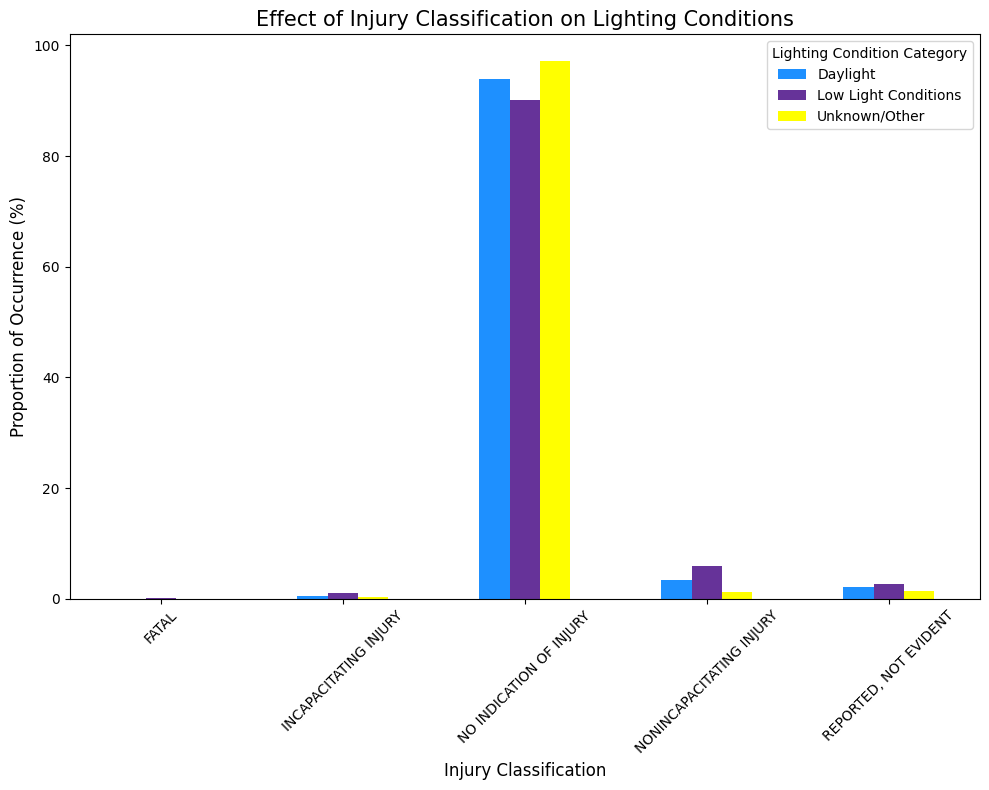

In [96]:
# Grouping the data by 'INJURY_CLASSIFICATION' and 'LIGHTING_CONDITION_CATEGORY'
grouped_lighting_df = crashes_final_df.groupby(['INJURY_CLASSIFICATION', 'LIGHTING_CONDITION_CATEGORY']).size().unstack(fill_value=0)

# Calculate the total occurrences for each lighting condition category
lighting_totals = grouped_lighting_df.sum(axis=0)

# Normalize the counts to percentages
normalized_lighting_df = grouped_lighting_df.div(lighting_totals, axis=1) * 100

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
normalized_lighting_df.plot.bar(ax=ax, color=('dodgerblue', 'rebeccapurple', 'yellow'))

# Adding titles and labels
plt.title('Effect of Injury Classification on Lighting Conditions', size=15)
plt.ylabel('Proportion of Occurrence (%)', size=12)
plt.xlabel('Injury Classification', size=12)
plt.xticks(rotation=45)
plt.legend(title='Lighting Condition Category')
plt.tight_layout()

# Show the plot
plt.show();

#### Use of safety equipment  
It is not surprising at all that using safety equipment consistently prevents injury and fatality. Although these categories are disaggregated by child, motorcycle, and car, we combine these to get an overall view of the effectiveness of safety equipment.

The data also include categories for equipment used improperly, but this is a very small proportion of the total.

In [97]:
safety_equip = pd.crosstab(crashes_final_df.SAFETY_EQUIPMENT_CATEGORY, 
            crashes_final_df.INJURY_CLASSIFICATION).T

safety_equip

SAFETY_EQUIPMENT_CATEGORY,Not Used,Unknown,Used
INJURY_CLASSIFICATION,,,
FATAL,63,268,67
INCAPACITATING INJURY,435,2595,2159
NO INDICATION OF INJURY,3396,267715,379609
NONINCAPACITATING INJURY,1002,13665,13993
"REPORTED, NOT EVIDENT",193,6443,9281


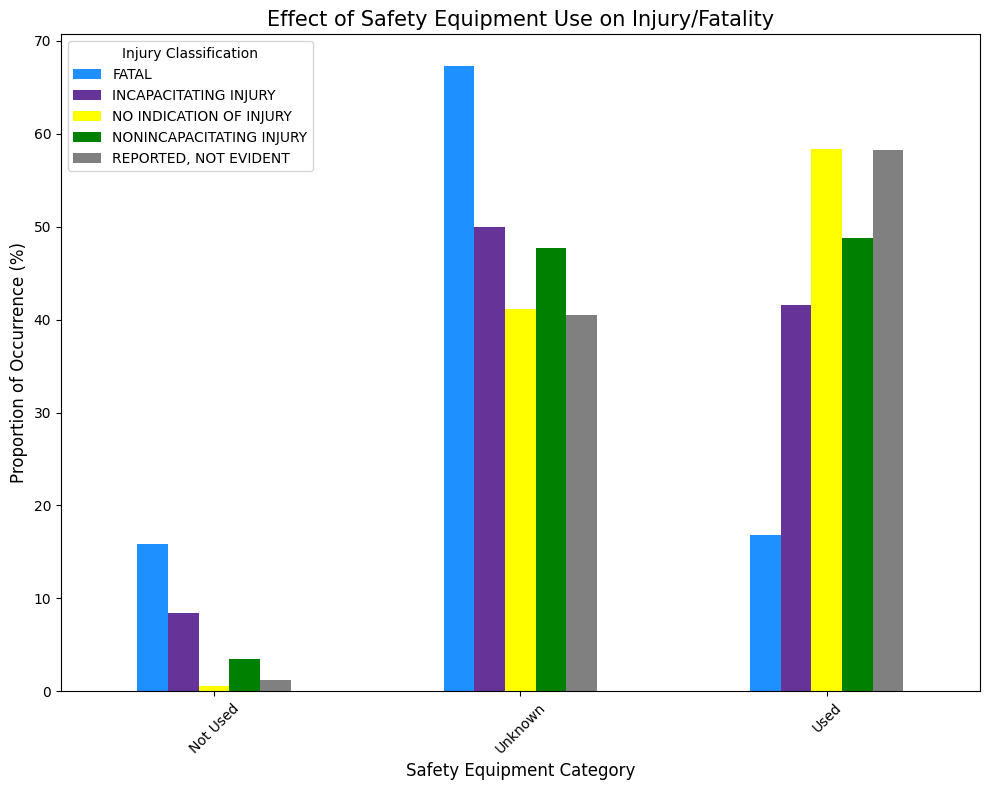

In [98]:
# Grouping the data by 'SAFETY_EQUIPMENT_CATEGORY' and 'INJURY_CLASSIFICATION'
grouped_df = crashes_final_df.groupby(['SAFETY_EQUIPMENT_CATEGORY', 'INJURY_CLASSIFICATION']).size().unstack(fill_value=0)

# Calculate the total occurrences for each injury classification
totals = grouped_df.sum(axis=0)

# Normalize the counts to percentages
normalized_df = grouped_df.div(totals, axis=1) * 100

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
normalized_df.plot.bar(ax=ax, color=('dodgerblue', 'rebeccapurple', 'yellow', 'green', 'grey'))

# Adding titles and labels
plt.title('Effect of Safety Equipment Use on Injury/Fatality', size=15)
plt.ylabel('Proportion of Occurrence (%)', size=12)
plt.xlabel('Safety Equipment Category', size=12)
plt.xticks(rotation=45)
plt.legend(title='Injury Classification')
plt.tight_layout()

# Show the plot
plt.show();

Drop null values from the columns that are missing data

In [99]:
# Drop ages < 0 and ages = 0 for AGE
crashes_final_df.loc[crashes_final_df.AGE < 0, 'AGE'] = np.nan
crashes_final_df.loc[(crashes_final_df.AGE == 0) & (crashes_final_df.PERSON_TYPE == 'DRIVER'), 'AGE'] = np.nan
crashes_final_df.dropna(subset = ['AGE'], inplace=True)

# Drop POSTED_SPEED_LIMIT = 0 or not divisible by 5
crashes_final_df.loc[crashes_final_df.POSTED_SPEED_LIMIT == 0, 'POSTED_SPEED_LIMIT'] = np.nan
crashes_final_df.loc[(crashes_final_df.POSTED_SPEED_LIMIT % 5) != 0, 'POSTED_SPEED_LIMIT'] = np.nan
crashes_final_df.dropna(subset = ['POSTED_SPEED_LIMIT'], inplace=True)

In [100]:
crashes_final_df.isna().sum()

CRASH_RECORD_ID                        0
POSTED_SPEED_LIMIT                     0
CRASH_HOUR                             0
CRASH_DAY_OF_WEEK                      0
CRASH_MONTH                            0
PERSON_TYPE                            0
AGE                                    0
SEX                                    0
INJURY_CLASSIFICATION                  0
BAC_RESULT                             0
UNIT_TYPE                              0
TRAVEL_DIRECTION                       0
MANEUVER_CATEGORY                      0
VEHICLE_USE_CATEGORY                  41
VEHICLE_TYPE_CATEGORY               1143
VEHICLE_DEFECT_CATEGORY                0
DRIVER_VISION_CATEGORY                 0
DRIVER_ACTION_CATEGORY                 0
PHYSICAL_CONDITION_CATEGORY            0
AIRBAG_DEPLOYMENT_CATEGORY             0
SAFETY_EQUIPMENT_CATEGORY              2
SEC_CONTRIBUTORY_CAUSE_CATEGORY     2934
PRIM_CONTRIBUTORY_CAUSE_CATEGORY     967
ROAD_DEFECT_CATEGORY                   0
ROADWAY_SURFACE_

In [101]:
crashes_final_df = crashes_final_df.dropna()

In [102]:
crashes_final_df = crashes_final_df.drop(columns=['CRASH_RECORD_ID', 'INJURY_CLASSIFICATION'])

In [103]:
crashes_final_df.shape

(682992, 30)

In [104]:
primary_causes = pd.crosstab(crashes_final_df.PRIM_CONTRIBUTORY_CAUSE_CATEGORY, 
            crashes_final_df.SEX)

primary_causes

SEX,F,M,X
PRIM_CONTRIBUTORY_CAUSE_CATEGORY,,,
Driver Error,155887,234671,386
Environmental Factors / Other,109973,167295,402
Vehicle Conditions,4795,9571,12


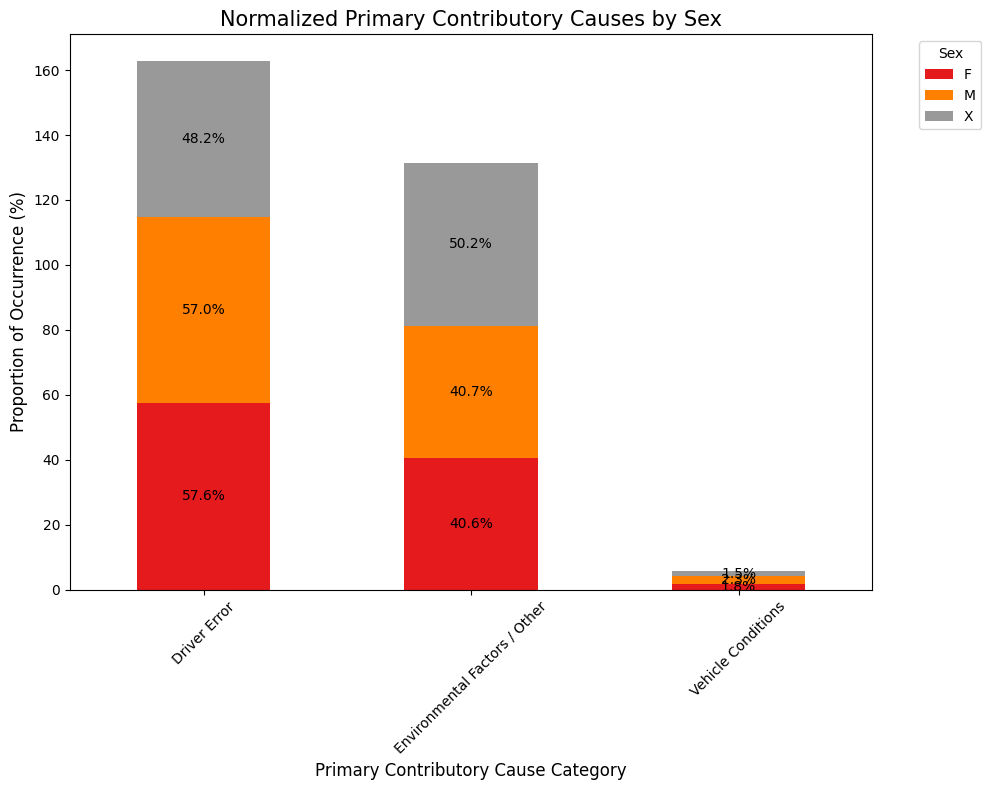

In [105]:
# Normalize the crosstab by column (i.e., per SEX)
normalized_primary_causes = primary_causes.div(primary_causes.sum(axis=0), axis=1) * 100

# Plotting the normalized data
fig, ax = plt.subplots(figsize=(10, 8))
normalized_primary_causes.plot.bar(ax=ax, stacked=True, colormap='Set1')

# Adding titles and labels
plt.title('Normalized Primary Contributory Causes by Sex', size=15)
plt.ylabel('Proportion of Occurrence (%)', size=12)
plt.xlabel('Primary Contributory Cause Category', size=12)
plt.xticks(rotation=45)
plt.legend(title='Sex', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels on the bars
for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show();

In [106]:
sec_causes = pd.crosstab(crashes_final_df.SEC_CONTRIBUTORY_CAUSE_CATEGORY, 
            crashes_final_df.SEX)

sec_causes

SEX,F,M,X
SEC_CONTRIBUTORY_CAUSE_CATEGORY,,,
Driver Error,62116,94845,148
Environmental Factors / Other,206225,312468,642
Vehicle Conditions,2314,4224,10


<Figure size 1200x800 with 0 Axes>

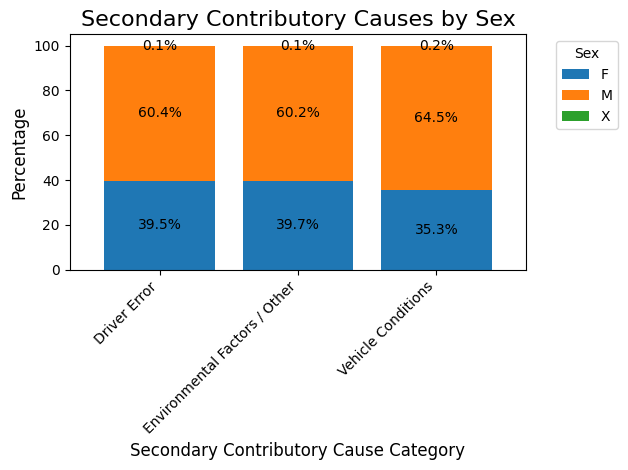

In [107]:
# Create the cross-tabulation
sec_causes = pd.crosstab(crashes_final_df.SEC_CONTRIBUTORY_CAUSE_CATEGORY, 
                         crashes_final_df.SEX)

# Calculate percentages
sec_causes_pct = sec_causes.div(sec_causes.sum(axis=1), axis=0) * 100

# Set up the plot
plt.figure(figsize=(12, 8))
ax = sec_causes_pct.plot(kind='bar', stacked=True, width=0.8)

# Customize the plot
plt.title('Secondary Contributory Causes by Sex', fontsize=16)
plt.xlabel('Secondary Contributory Cause Category', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Sex', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

# Add percentage labels on the bars
for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show();

In [108]:
driver_action = pd.crosstab(crashes_final_df.DRIVER_ACTION_CATEGORY, 
            crashes_final_df.VEHICLE_DEFECT_CATEGORY)

driver_action

VEHICLE_DEFECT_CATEGORY,Braking System Issues,Mechanical/System Issues,No Defect,Tire and Wheel Issues,Unknown
DRIVER_ACTION_CATEGORY,,,,,
Aggressive/Improper Driving,1067,918,98009,283,67552
Distracted Driving,12,35,1942,20,1660
Failure to Yield/Traffic Violations,1760,1302,103991,870,73968
Normal Behavior,599,1662,76117,444,115689
Unknown,534,1225,39553,389,93391


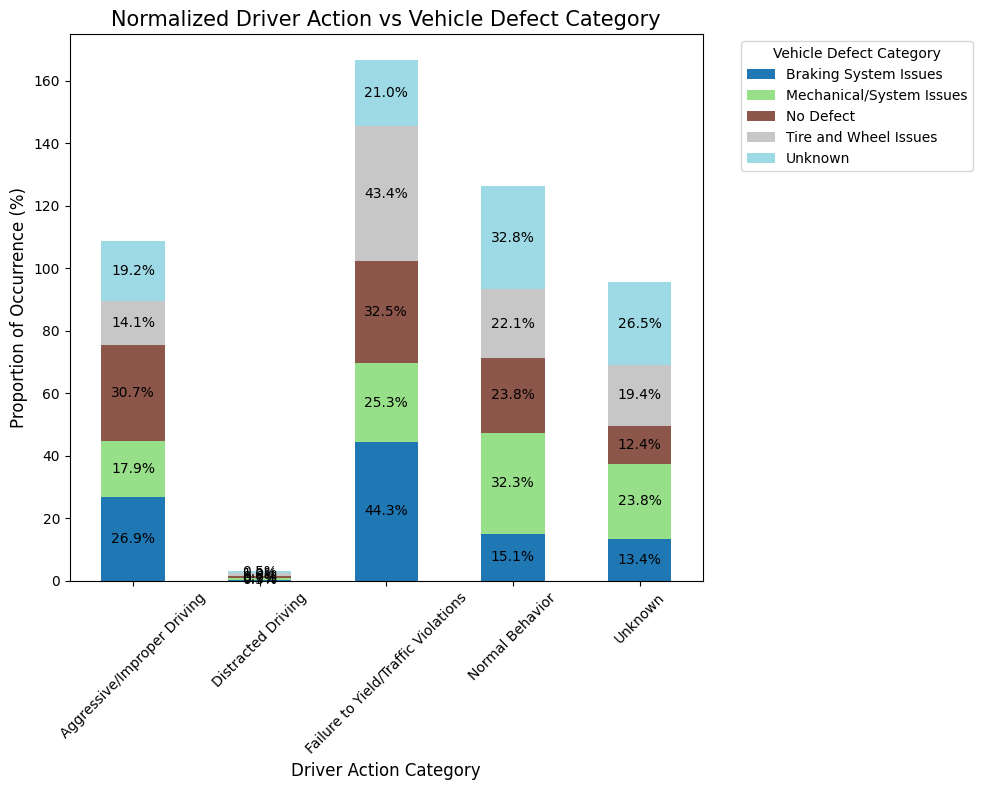

In [109]:
# Normalize the data column-wise (i.e., per VEHICLE_DEFECT_CATEGORY)
normalized_driver_action = driver_action.div(driver_action.sum(axis=0), axis=1) * 100

# Plotting the normalized data
fig, ax = plt.subplots(figsize=(10, 8))
normalized_driver_action.plot.bar(ax=ax, stacked=True, colormap='tab20')

# Adding titles and labels
plt.title('Normalized Driver Action vs Vehicle Defect Category', size=15)
plt.ylabel('Proportion of Occurrence (%)', size=12)
plt.xlabel('Driver Action Category', size=12)
plt.xticks(rotation=45)
plt.legend(title='Vehicle Defect Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add percentage labels on the bars
for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show();

In [110]:
# Create a subset of the dataset where PERSON_TYPE == 'DRIVER'
crashes_driver_df = crashes_final_df[crashes_final_df['PERSON_TYPE'] == 'DRIVER']
# Drop the PERSON_TYPE column from the dataset
crashes_driver_df = crashes_driver_df.drop(columns='PERSON_TYPE', axis=1)

# Display the first few rows of the new dataset to verify
crashes_driver_df.head()

,POSTED_SPEED_LIMIT,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,AGE,SEX,BAC_RESULT,UNIT_TYPE,TRAVEL_DIRECTION,MANEUVER_CATEGORY,...,PRIM_CONTRIBUTORY_CAUSE_CATEGORY,ROAD_DEFECT_CATEGORY,ROADWAY_SURFACE_CATEGORY,ALIGNMENT_CATEGORY,TRAFFICWAY_TYPE_CATEGORY,FIRST_CRASH_TYPE_CATEGORY,TRAFFIC_CONTROL_CATEGORY,DEVICE_CONDITION_CATEGORY,WEATHER_CONDITION_CATEGORY,LIGHTING_CONDITION_CATEGORY
0,30.0,19,3,9,51.0,M,TEST NOT OFFERED,DRIVER,N,Normal Driving,...,Environmental Factors / Other,No Defects,Normal/Dry Conditions,Straight Roads,Intersection Types,Vehicle-to-Vehicle Collisions,Traffic Control Devices,Functioning Devices,Clear/Normal Conditions,Low Light Conditions
10,50.0,18,6,9,33.0,M,TEST NOT OFFERED,DRIVER,E,Normal Driving,...,Driver Error,No Defects,Normal/Dry Conditions,Straight Roads,Divided Roads,Vehicle-to-Vehicle Collisions,Miscellaneous/Unknown,Unknown/Other,Clear/Normal Conditions,Low Light Conditions
18,30.0,23,4,8,24.0,M,TEST NOT OFFERED,DRIVER,E,Normal Driving,...,Driver Error,No Defects,Normal/Dry Conditions,Straight Roads,Undivided Roads,Vehicle-to-Vehicle Collisions,Miscellaneous/Unknown,Unknown/Other,Clear/Normal Conditions,Low Light Conditions
22,15.0,12,6,8,45.0,M,TEST NOT OFFERED,DRIVER,W,Normal Driving,...,Driver Error,No Defects,Normal/Dry Conditions,Straight Roads,Other/Unclassified Types,Vehicle-to-Vehicle Collisions,Miscellaneous/Unknown,Functioning Devices,Clear/Normal Conditions,Daylight
26,25.0,8,3,11,26.0,M,"TEST PERFORMED, RESULTS UNKNOWN",DRIVER,W,Normal Driving,...,Environmental Factors / Other,No Defects,Normal/Dry Conditions,Curved Roads,Undivided Roads,Other/Non-Collision Events,Miscellaneous/Unknown,Unknown/Other,Clear/Normal Conditions,Daylight


In [111]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit and transform the PRIM_CONTRIBUTORY_CAUSE_CATEGORY column to numerical values
crashes_driver_df['PRIM_CONTRIBUTORY_CAUSE_NUM'] = label_encoder.fit_transform(crashes_driver_df['PRIM_CONTRIBUTORY_CAUSE_CATEGORY'])

crashes_driver_df = crashes_driver_df.drop(columns='PRIM_CONTRIBUTORY_CAUSE_CATEGORY', axis=1)

# Check the mapping
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print('\n')

# Display the dataframe with the new numerical column
crashes_driver_df.head()

{'Driver Error': 0, 'Environmental Factors / Other': 1, 'Vehicle Conditions': 2}




,POSTED_SPEED_LIMIT,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,AGE,SEX,BAC_RESULT,UNIT_TYPE,TRAVEL_DIRECTION,MANEUVER_CATEGORY,...,ROAD_DEFECT_CATEGORY,ROADWAY_SURFACE_CATEGORY,ALIGNMENT_CATEGORY,TRAFFICWAY_TYPE_CATEGORY,FIRST_CRASH_TYPE_CATEGORY,TRAFFIC_CONTROL_CATEGORY,DEVICE_CONDITION_CATEGORY,WEATHER_CONDITION_CATEGORY,LIGHTING_CONDITION_CATEGORY,PRIM_CONTRIBUTORY_CAUSE_NUM
0,30.0,19,3,9,51.0,M,TEST NOT OFFERED,DRIVER,N,Normal Driving,...,No Defects,Normal/Dry Conditions,Straight Roads,Intersection Types,Vehicle-to-Vehicle Collisions,Traffic Control Devices,Functioning Devices,Clear/Normal Conditions,Low Light Conditions,1
10,50.0,18,6,9,33.0,M,TEST NOT OFFERED,DRIVER,E,Normal Driving,...,No Defects,Normal/Dry Conditions,Straight Roads,Divided Roads,Vehicle-to-Vehicle Collisions,Miscellaneous/Unknown,Unknown/Other,Clear/Normal Conditions,Low Light Conditions,0
18,30.0,23,4,8,24.0,M,TEST NOT OFFERED,DRIVER,E,Normal Driving,...,No Defects,Normal/Dry Conditions,Straight Roads,Undivided Roads,Vehicle-to-Vehicle Collisions,Miscellaneous/Unknown,Unknown/Other,Clear/Normal Conditions,Low Light Conditions,0
22,15.0,12,6,8,45.0,M,TEST NOT OFFERED,DRIVER,W,Normal Driving,...,No Defects,Normal/Dry Conditions,Straight Roads,Other/Unclassified Types,Vehicle-to-Vehicle Collisions,Miscellaneous/Unknown,Functioning Devices,Clear/Normal Conditions,Daylight,0
26,25.0,8,3,11,26.0,M,"TEST PERFORMED, RESULTS UNKNOWN",DRIVER,W,Normal Driving,...,No Defects,Normal/Dry Conditions,Curved Roads,Undivided Roads,Other/Non-Collision Events,Miscellaneous/Unknown,Unknown/Other,Clear/Normal Conditions,Daylight,1


### Split the data for cleaning and training

In [112]:
crashes_final = crashes_driver_df.copy()

In [113]:
X = crashes_final.drop(columns='PRIM_CONTRIBUTORY_CAUSE_NUM', axis=1)

y = crashes_final['PRIM_CONTRIBUTORY_CAUSE_NUM']

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [114]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape

((512016, 28), (170673, 28))

### Feature Engineering

In [115]:
X_train.dtypes

POSTED_SPEED_LIMIT                 float64
CRASH_HOUR                           int64
CRASH_DAY_OF_WEEK                    int64
CRASH_MONTH                          int64
AGE                                float64
SEX                                 object
BAC_RESULT                          object
UNIT_TYPE                           object
TRAVEL_DIRECTION                    object
MANEUVER_CATEGORY                   object
VEHICLE_USE_CATEGORY                object
VEHICLE_TYPE_CATEGORY               object
VEHICLE_DEFECT_CATEGORY             object
DRIVER_VISION_CATEGORY              object
DRIVER_ACTION_CATEGORY              object
PHYSICAL_CONDITION_CATEGORY         object
AIRBAG_DEPLOYMENT_CATEGORY          object
SAFETY_EQUIPMENT_CATEGORY           object
SEC_CONTRIBUTORY_CAUSE_CATEGORY     object
ROAD_DEFECT_CATEGORY                object
ROADWAY_SURFACE_CATEGORY            object
ALIGNMENT_CATEGORY                  object
TRAFFICWAY_TYPE_CATEGORY            object
FIRST_CRASH

In [116]:
# display categorical variables

categorical = [col for col in X_train.columns if X_train[col].dtypes == 'O']

categorical

['SEX',
 'BAC_RESULT',
 'UNIT_TYPE',
 'TRAVEL_DIRECTION',
 'MANEUVER_CATEGORY',
 'VEHICLE_USE_CATEGORY',
 'VEHICLE_TYPE_CATEGORY',
 'VEHICLE_DEFECT_CATEGORY',
 'DRIVER_VISION_CATEGORY',
 'DRIVER_ACTION_CATEGORY',
 'PHYSICAL_CONDITION_CATEGORY',
 'AIRBAG_DEPLOYMENT_CATEGORY',
 'SAFETY_EQUIPMENT_CATEGORY',
 'SEC_CONTRIBUTORY_CAUSE_CATEGORY',
 'ROAD_DEFECT_CATEGORY',
 'ROADWAY_SURFACE_CATEGORY',
 'ALIGNMENT_CATEGORY',
 'TRAFFICWAY_TYPE_CATEGORY',
 'FIRST_CRASH_TYPE_CATEGORY',
 'TRAFFIC_CONTROL_CATEGORY',
 'DEVICE_CONDITION_CATEGORY',
 'WEATHER_CONDITION_CATEGORY',
 'LIGHTING_CONDITION_CATEGORY']

In [117]:
# display numerical variables

numerical = [col for col in X_train.columns if X_train[col].dtypes != 'O']

numerical

['POSTED_SPEED_LIMIT', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'AGE']

In [118]:
# check missing values in numerical variables in X_train

X_train[numerical].isnull().sum()

POSTED_SPEED_LIMIT    0
CRASH_HOUR            0
CRASH_DAY_OF_WEEK     0
CRASH_MONTH           0
AGE                   0
dtype: int64

In [119]:
# print categorical variables with missing data

for col in categorical:
    if X_train[col].isnull().mean()>0:
        print(col, (X_train[col].isnull().mean()))

In [120]:
# check missing values in numerical variables in X_test

X_test[numerical].isnull().sum()

POSTED_SPEED_LIMIT    0
CRASH_HOUR            0
CRASH_DAY_OF_WEEK     0
CRASH_MONTH           0
AGE                   0
dtype: int64

In [121]:
X_train.mode()

,POSTED_SPEED_LIMIT,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,AGE,SEX,BAC_RESULT,UNIT_TYPE,TRAVEL_DIRECTION,MANEUVER_CATEGORY,...,SEC_CONTRIBUTORY_CAUSE_CATEGORY,ROAD_DEFECT_CATEGORY,ROADWAY_SURFACE_CATEGORY,ALIGNMENT_CATEGORY,TRAFFICWAY_TYPE_CATEGORY,FIRST_CRASH_TYPE_CATEGORY,TRAFFIC_CONTROL_CATEGORY,DEVICE_CONDITION_CATEGORY,WEATHER_CONDITION_CATEGORY,LIGHTING_CONDITION_CATEGORY
0,30.0,15,6,9,25.0,M,TEST NOT OFFERED,DRIVER,N,Normal Driving,...,Environmental Factors / Other,No Defects,Normal/Dry Conditions,Straight Roads,Undivided Roads,Vehicle-to-Vehicle Collisions,Miscellaneous/Unknown,Unknown/Other,Clear/Normal Conditions,Daylight


In [122]:
# print percentage of missing values in the categorical variables in training set

X_train[categorical].isnull().mean()

SEX                                0.0
BAC_RESULT                         0.0
UNIT_TYPE                          0.0
TRAVEL_DIRECTION                   0.0
MANEUVER_CATEGORY                  0.0
VEHICLE_USE_CATEGORY               0.0
VEHICLE_TYPE_CATEGORY              0.0
VEHICLE_DEFECT_CATEGORY            0.0
DRIVER_VISION_CATEGORY             0.0
DRIVER_ACTION_CATEGORY             0.0
PHYSICAL_CONDITION_CATEGORY        0.0
AIRBAG_DEPLOYMENT_CATEGORY         0.0
SAFETY_EQUIPMENT_CATEGORY          0.0
SEC_CONTRIBUTORY_CAUSE_CATEGORY    0.0
ROAD_DEFECT_CATEGORY               0.0
ROADWAY_SURFACE_CATEGORY           0.0
ALIGNMENT_CATEGORY                 0.0
TRAFFICWAY_TYPE_CATEGORY           0.0
FIRST_CRASH_TYPE_CATEGORY          0.0
TRAFFIC_CONTROL_CATEGORY           0.0
DEVICE_CONDITION_CATEGORY          0.0
WEATHER_CONDITION_CATEGORY         0.0
LIGHTING_CONDITION_CATEGORY        0.0
dtype: float64

In [123]:
# check missing values in categorical variables in X_test

X_test[categorical].isnull().sum()

SEX                                0
BAC_RESULT                         0
UNIT_TYPE                          0
TRAVEL_DIRECTION                   0
MANEUVER_CATEGORY                  0
VEHICLE_USE_CATEGORY               0
VEHICLE_TYPE_CATEGORY              0
VEHICLE_DEFECT_CATEGORY            0
DRIVER_VISION_CATEGORY             0
DRIVER_ACTION_CATEGORY             0
PHYSICAL_CONDITION_CATEGORY        0
AIRBAG_DEPLOYMENT_CATEGORY         0
SAFETY_EQUIPMENT_CATEGORY          0
SEC_CONTRIBUTORY_CAUSE_CATEGORY    0
ROAD_DEFECT_CATEGORY               0
ROADWAY_SURFACE_CATEGORY           0
ALIGNMENT_CATEGORY                 0
TRAFFICWAY_TYPE_CATEGORY           0
FIRST_CRASH_TYPE_CATEGORY          0
TRAFFIC_CONTROL_CATEGORY           0
DEVICE_CONDITION_CATEGORY          0
WEATHER_CONDITION_CATEGORY         0
LIGHTING_CONDITION_CATEGORY        0
dtype: int64

In [124]:
# check missing values in X_train

X_train.isnull().sum()

POSTED_SPEED_LIMIT                 0
CRASH_HOUR                         0
CRASH_DAY_OF_WEEK                  0
CRASH_MONTH                        0
AGE                                0
SEX                                0
BAC_RESULT                         0
UNIT_TYPE                          0
TRAVEL_DIRECTION                   0
MANEUVER_CATEGORY                  0
VEHICLE_USE_CATEGORY               0
VEHICLE_TYPE_CATEGORY              0
VEHICLE_DEFECT_CATEGORY            0
DRIVER_VISION_CATEGORY             0
DRIVER_ACTION_CATEGORY             0
PHYSICAL_CONDITION_CATEGORY        0
AIRBAG_DEPLOYMENT_CATEGORY         0
SAFETY_EQUIPMENT_CATEGORY          0
SEC_CONTRIBUTORY_CAUSE_CATEGORY    0
ROAD_DEFECT_CATEGORY               0
ROADWAY_SURFACE_CATEGORY           0
ALIGNMENT_CATEGORY                 0
TRAFFICWAY_TYPE_CATEGORY           0
FIRST_CRASH_TYPE_CATEGORY          0
TRAFFIC_CONTROL_CATEGORY           0
DEVICE_CONDITION_CATEGORY          0
WEATHER_CONDITION_CATEGORY         0
L

In [125]:
# check missing values in X_test

X_test.isnull().sum()

POSTED_SPEED_LIMIT                 0
CRASH_HOUR                         0
CRASH_DAY_OF_WEEK                  0
CRASH_MONTH                        0
AGE                                0
SEX                                0
BAC_RESULT                         0
UNIT_TYPE                          0
TRAVEL_DIRECTION                   0
MANEUVER_CATEGORY                  0
VEHICLE_USE_CATEGORY               0
VEHICLE_TYPE_CATEGORY              0
VEHICLE_DEFECT_CATEGORY            0
DRIVER_VISION_CATEGORY             0
DRIVER_ACTION_CATEGORY             0
PHYSICAL_CONDITION_CATEGORY        0
AIRBAG_DEPLOYMENT_CATEGORY         0
SAFETY_EQUIPMENT_CATEGORY          0
SEC_CONTRIBUTORY_CAUSE_CATEGORY    0
ROAD_DEFECT_CATEGORY               0
ROADWAY_SURFACE_CATEGORY           0
ALIGNMENT_CATEGORY                 0
TRAFFICWAY_TYPE_CATEGORY           0
FIRST_CRASH_TYPE_CATEGORY          0
TRAFFIC_CONTROL_CATEGORY           0
DEVICE_CONDITION_CATEGORY          0
WEATHER_CONDITION_CATEGORY         0
L

In [126]:
# Identify categorical and numerical columns
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

# Create the OneHotEncoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_columns),
        ('cat', ohe, categorical_columns)
    ])

# Fit the preprocessor on X_train and transform both X_train and X_test
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Get feature names after encoding
def get_feature_names(column_transformer):
    """Get feature names from all transformers."""
    output_features = []
    
    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(pipe, 'get_feature_names_out'):
                if isinstance(features, str):
                    output_features.extend(pipe.get_feature_names_out([features]))
                else:
                    output_features.extend(pipe.get_feature_names_out(features))
            elif hasattr(pipe, 'get_feature_names'):
                output_features.extend(pipe.get_feature_names(features))
            else:
                output_features.extend(features)
    
    return output_features

feature_names = get_feature_names(preprocessor)

# Convert to DataFrames
X_train_encoded = pd.DataFrame(X_train_encoded, columns=feature_names)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=feature_names)

print("Shape of X_train after encoding:", X_train_encoded.shape)
print('\n')
print("Shape of X_test after encoding:", X_test_encoded.shape)
print('\n')
print("Number of categorical columns encoded:", len(categorical_columns))
print('\n')
print("Total number of features after encoding:", len(feature_names))
print('\n')

# Display first few rows and columns of encoded data
print("\nFirst few columns of encoded X_train:")
print('\n')
X_train_encoded.iloc[:5, :10]

Shape of X_train after encoding: (512016, 100)


Shape of X_test after encoding: (170673, 100)


Number of categorical columns encoded: 23


Total number of features after encoding: 100



First few columns of encoded X_train:




,POSTED_SPEED_LIMIT,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,AGE,SEX_F,SEX_M,SEX_X,BAC_RESULT_TEST NOT OFFERED,"BAC_RESULT_TEST PERFORMED, RESULTS UNKNOWN"
0,30.0,15.0,7.0,12.0,28.0,1.0,0.0,0.0,1.0,0.0
1,30.0,13.0,4.0,8.0,64.0,0.0,1.0,0.0,1.0,0.0
2,30.0,12.0,6.0,1.0,20.0,0.0,1.0,0.0,1.0,0.0
3,35.0,13.0,4.0,6.0,46.0,1.0,0.0,0.0,1.0,0.0
4,20.0,1.0,2.0,8.0,33.0,0.0,1.0,0.0,1.0,0.0


### Dummy Classifier

In [127]:
dummy_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('dc', DummyClassifier(strategy='most_frequent'))
])

Dummy Classifier TEST Recall Score (macro): 0.3333333333333333
Dummy Classifier TEST Precision Score (macro): 0.1909479921643533
Dummy Classifier TEST F1 Score (macro): 0.24280601892898032
Dummy Classifier TEST Accuracy Score: 0.5728439764930598


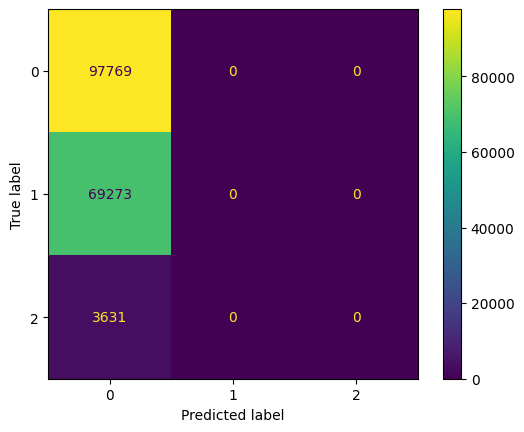

In [128]:
# Fit the dummy pipeline
dummy_pipe.fit(X_train_encoded, y_train)

# Get the predictions from the dummy classifier on the test set
y_pred = dummy_pipe.predict(X_test_encoded)

# Display the confusion matrix
ConfusionMatrixDisplay.from_estimator(dummy_pipe, X_test_encoded, y_test)

# Calculate and print performance metrics for multiclass
print('Dummy Classifier TEST Recall Score (macro):', recall_score(y_test, y_pred, average='macro'))
print('Dummy Classifier TEST Precision Score (macro):', precision_score(y_test, y_pred, average='macro'))
print('Dummy Classifier TEST F1 Score (macro):', f1_score(y_test, y_pred, average='macro'))
print('Dummy Classifier TEST Accuracy Score:', accuracy_score(y_test, y_pred))

 ## MODELS
 
 ### Decision Tree

Accuracy: 0.67
AUC: 0.66
Precision (Weighted): 0.67
Recall (Weighted): 0.67
F1 Score (Weighted): 0.67

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72     97769
           1       0.61      0.62      0.62     69273
           2       0.27      0.29      0.28      3631

    accuracy                           0.67    170673
   macro avg       0.54      0.54      0.54    170673
weighted avg       0.67      0.67      0.67    170673



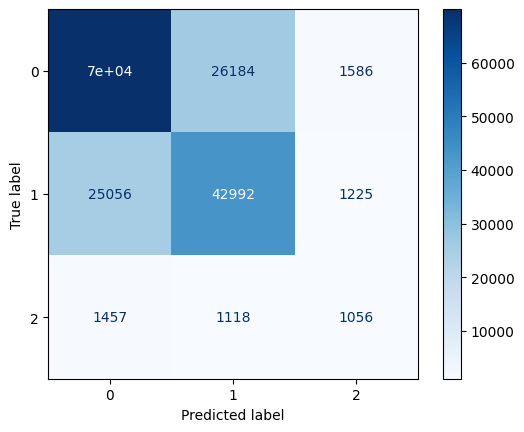

In [129]:
clf_pipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('clf', DecisionTreeClassifier(random_state=10))
])

# Fit the model
clf_pipe.fit(X_train_encoded, y_train)

# Make predictions for test data
y_pred = clf_pipe.predict(X_test_encoded)
y_prob = clf_pipe.predict_proba(X_test_encoded)  # Use probabilities for AUC

# Calculate accuracy
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.2f}')

# Calculate AUC score for multiclass
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')  # 'ovr' is one-vs-rest, 'ovo' is one-vs-one
print(f'AUC: {roc_auc:.2f}')

# Calculate additional metrics (using 'weighted' for multiclass classification)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Precision (Weighted): {precision:.2f}')
print(f'Recall (Weighted): {recall:.2f}')
print(f'F1 Score (Weighted): {f1:.2f}')

# Print classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create and print confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Fix the confusion matrix display by accessing the classifier classes via the pipeline
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=clf_pipe.named_steps['clf'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show();

Confusion Matrix Analysis:

- True Class 0:  
 **70,000** correctly predicted as 0.  
 **26,184** misclassified as 1.  
 **1,586** misclassified as 2.  

- True Class 1:  
 **25,056** misclassified as 0.  
 **42,992** correctly predicted as 1.  
 **1,225** misclassified as 2.  

- True Class 2:  
 **1,457** misclassified as 0.  
 **1,118** misclassified as 1.  
 **1,056** correctly predicted as 2.  

Key Metrics Breakdown:  

- Accuracy: 0.67  
The overall accuracy is 67%, meaning that 67% of predictions across all classes are correct.  

AUC (0.66):
The area under the curve indicates the model's ability to distinguish between classes, and at 0.66, it suggests moderate discrimination.

Precision (Weighted: 0.67):
Weighted precision, which takes class imbalance into account, is 0.67. This shows that the model performs reasonably well for class 0 and class 1, but class 2 drags down the overall precision due to its low precision value.

Recall (Weighted: 0.67):  
Recall, also weighted by class frequencies, shows that the model correctly identifies 67% of true positive instances across all classes.  

F1 Score (Weighted: 0.67):  
The weighted F1 score is a balance between precision and recall, and at 0.67, it reflects the model's overall performance.
Classification Report Highlights:  

Class 0:  
Precision = 0.73, Recall = 0.72, F1-Score = 0.72  
Class 0 has the highest precision and recall, meaning the model is good at correctly predicting this class, which is expected given the larger number of samples for class 0.  

- Class 1:  
Precision = 0.61, Recall = 0.62, F1-Score = 0.62
Class 1 performs decently but slightly worse than class 0, with a significant number of misclassifications into class 0 (25,056 instances).  

- Class 2:
Precision = 0.27, Recall = 0.29, F1-Score = 0.28 Class 2 continues to have the lowest performance, as evidenced by the low precision, recall, and F1 scores. The model struggles to predict class 2 correctly, with a significant number of instances being misclassified into classes 0 and 1.

- Macro vs. Weighted Averages:

Macro Average:
The macro average precision, recall, and F1 score (0.54) provide a simple average across all classes without considering class imbalance. The lower scores for class 2 are evident here.

Weighted Average:
The weighted averages (0.67 for precision, recall, and F1) consider the class imbalance, so the performance of class 0 and class 1 dominates these metrics.

### Random Forest

Training Precision (Weighted):  0.7513267481490454
Testing Precision (Weighted):  0.7484779358889332



Training Recall (Weighted):  0.6989176119496265
Testing Recall (Weighted):  0.6965776660631734



Training Accuracy:  0.6989176119496265
Testing Accuracy:  0.6965776660631734



Training F1-Score (Weighted):  0.7179730326760024
Testing F1-Score (Weighted):  0.7154758053593205


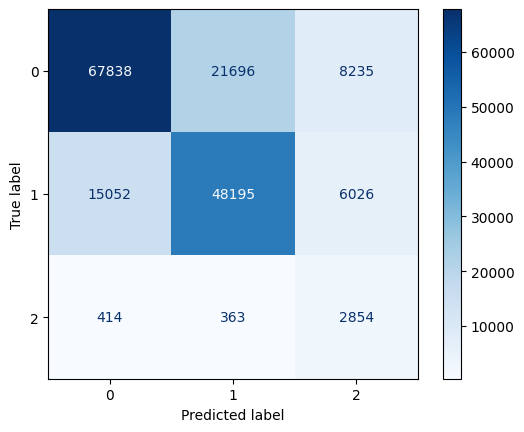

In [130]:
# Pipeline with RandomForestClassifier
rfpipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('classifier', RandomForestClassifier(max_depth=10, class_weight='balanced_subsample'))
])

# Fit the model
rfpipe.fit(X_train_encoded, y_train)

# Evaluation of Model
y_hat_train = rfpipe.predict(X_train_encoded)
y_hat_test = rfpipe.predict(X_test_encoded)

# Use 'weighted' average for multiclass classification metrics
print('Training Precision (Weighted): ', precision_score(y_train, y_hat_train, average='weighted'))
print('Testing Precision (Weighted): ', precision_score(y_test, y_hat_test, average='weighted'))
print('\n\n')

print('Training Recall (Weighted): ', recall_score(y_train, y_hat_train, average='weighted'))
print('Testing Recall (Weighted): ', recall_score(y_test, y_hat_test, average='weighted'))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score (Weighted): ', f1_score(y_train, y_hat_train, average='weighted'))
print('Testing F1-Score (Weighted): ', f1_score(y_test, y_hat_test, average='weighted'))

# Create and print confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=rfpipe.named_steps['classifier'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show();

### Logistic Regression

Training Precision (Weighted):  0.750262360236798
Testing Precision (Weighted):  0.7490292489671748



Training Recall (Weighted):  0.7079602981156838
Testing Recall (Weighted):  0.7069952482232105



Training Accuracy:  0.7079602981156838
Testing Accuracy:  0.7069952482232105



Training F1-Score (Weighted):  0.7219137559574348
Testing F1-Score (Weighted):  0.7207034162057839


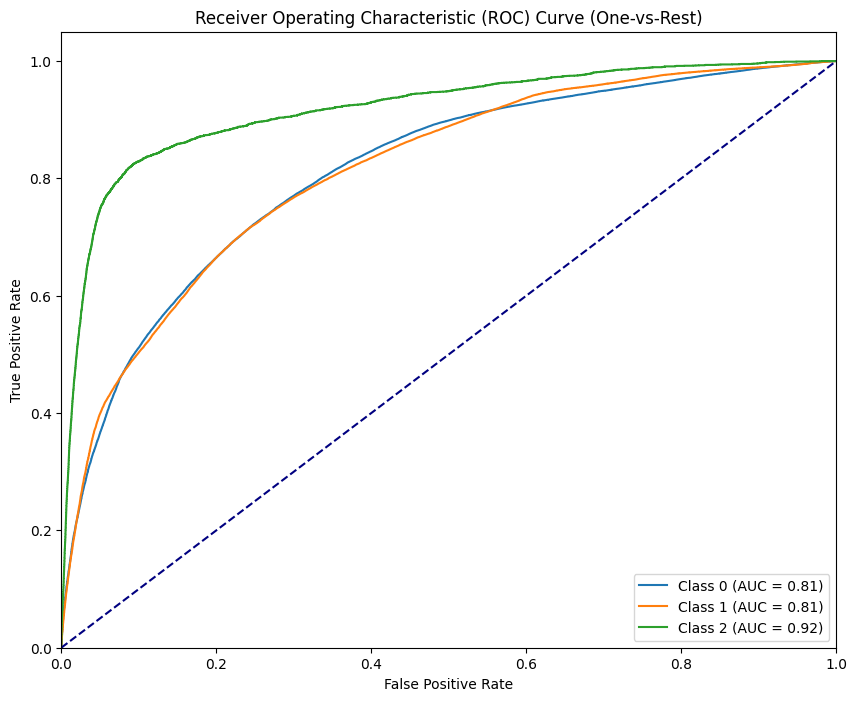

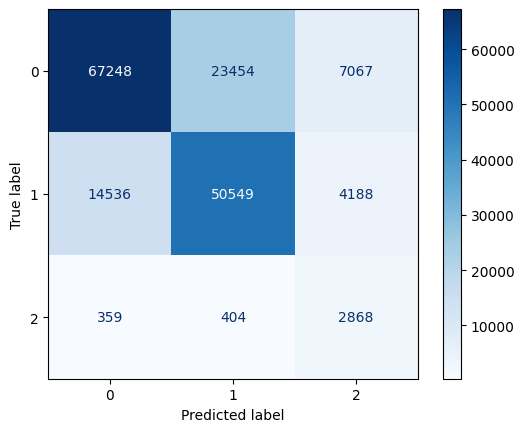

In [131]:
# Logistic Regression pipeline with best parameters
logpipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=850))
])

logpipe.fit(X_train_encoded, y_train)

# Evaluation of Model
y_hat_train = logpipe.predict(X_train_encoded)
y_hat_test = logpipe.predict(X_test_encoded)

# Use 'weighted' average for multiclass classification metrics
print('Training Precision (Weighted): ', precision_score(y_train, y_hat_train, average='weighted'))
print('Testing Precision (Weighted): ', precision_score(y_test, y_hat_test, average='weighted'))
print('\n\n')

print('Training Recall (Weighted): ', recall_score(y_train, y_hat_train, average='weighted'))
print('Testing Recall (Weighted): ', recall_score(y_test, y_hat_test, average='weighted'))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score (Weighted): ', f1_score(y_train, y_hat_train, average='weighted'))
print('Testing F1-Score (Weighted): ', f1_score(y_test, y_hat_test, average='weighted'))

# Multiclass ROC-AUC
y_score = logpipe.decision_function(X_test_encoded)

# roc_curve for multiclass (One-vs-Rest approach)
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(logpipe.named_steps['classifier'].classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()

# Create and print confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=logpipe.named_steps['classifier'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show();

### XGBoost

Training Precision (Weighted):  0.758497198269582
Testing Precision (Weighted):  0.7590728220577896



Training Recall (Weighted):  0.7609684072372739
Testing Recall (Weighted):  0.7613213572152596



Training Accuracy:  0.7609684072372739
Testing Accuracy:  0.7613213572152596



Training F1-Score (Weighted):  0.755265928018414
Testing F1-Score (Weighted):  0.7554718042957111


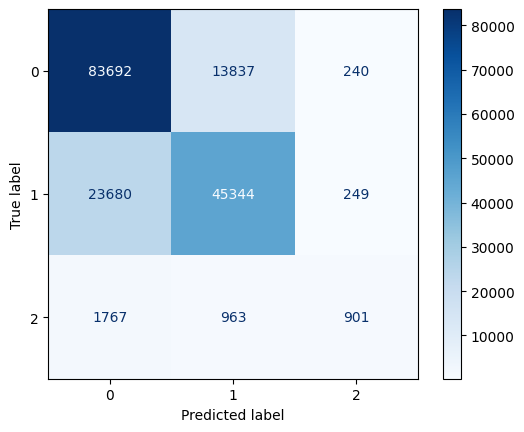

In [132]:
# XGBoost pipeline with best parameters
xgpipe = Pipeline(steps=[
    ('ss', StandardScaler()),
    ('classifier', XGBClassifier(max_depth=4, eta=0.1, scale_pos_weight=700, tree_method='hist'))
])

# Fit the model
xgpipe.fit(X_train_encoded, y_train)

# Evaluation of the model
y_hat_train = xgpipe.predict(X_train_encoded)
y_hat_test = xgpipe.predict(X_test_encoded)

# Use 'weighted' average for multiclass classification metrics
print('Training Precision (Weighted): ', precision_score(y_train, y_hat_train, average='weighted'))
print('Testing Precision (Weighted): ', precision_score(y_test, y_hat_test, average='weighted'))
print('\n\n')

print('Training Recall (Weighted): ', recall_score(y_train, y_hat_train, average='weighted'))
print('Testing Recall (Weighted): ', recall_score(y_test, y_hat_test, average='weighted'))
print('\n\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
print('\n\n')

print('Training F1-Score (Weighted): ', f1_score(y_train, y_hat_train, average='weighted'))
print('Testing F1-Score (Weighted): ', f1_score(y_test, y_hat_test, average='weighted'))

# Create and print confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=xgpipe.named_steps['classifier'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show();